</font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

In [1]:
filename_version='2dot18'

In [2]:
import sys
sys.path.append("/Users/pauljacob/Library/Python/3.8/lib/python/site-packages")

In [3]:
#file structure
!pip3 install cookiecutter

#general
!pip3 install --upgrade pip
!pip3 install ipython-autotime --quiet


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
%load_ext autotime

time: 264 µs (started: 2022-11-30 20:18:08 -08:00)


## Import Libraries

In [5]:
#get libraries
import pandas as pd
import os
import numpy as np


#get visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns



#ML preprocessing
from sklearn.preprocessing import StandardScaler

#get ML functions
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from sklearn import __version__ as sklearn_version
import datetime


#get ML metric functions
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import log_loss

#get icr module and associated common functions
import in_vehicle_coupon_recommendation as icr
from in_vehicle_coupon_recommendation import p, rcp, rpp, rcr, sr, pl, pdc, save_and_return_data_frame, initialize_custom_notebook_settings

#sound alert
from IPython.display import Audio

time: 1.9 s (started: 2022-11-30 20:18:08 -08:00)


In [6]:
#initialize notebook
initialize_custom_notebook_settings()

time: 2 ms (started: 2022-11-30 20:18:10 -08:00)


## Get In-Vehicle Coupon Recommendation Dataset

In [7]:
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'in-vehicle-coupon-recommendation.csv'))
df = df.sample(frac=1, random_state=200)
#p(df)

time: 40.2 ms (started: 2022-11-30 20:18:10 -08:00)


<font size="5"><a id='[Data_Wrangling]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Wrangling]'>**Data Wrangling**</a> </font>

In [8]:
#rename 'passanger' and 'coupon' column
df = df.rename(columns={'passanger':'passenger', 'coupon':'coupon_venue_type'})


#decode string 'age' values to (explicit) string age ranges
column_name_age_value_list = list(df.loc[:, 'age'].unique())
column_name_age_value_list_cleaned_up = ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']
column_name_age_value_dict = dict(zip(column_name_age_value_list, column_name_age_value_list_cleaned_up))
df.loc[:, 'age'] = df.loc[:, 'age'].replace(column_name_age_value_dict)

del column_name_age_value_dict, column_name_age_value_list, column_name_age_value_list_cleaned_up


#drop column 'toCoupon_GEQ5min' because all 1's
column_name_list_not_toCoupon_GEQ5min = [column_name for column_name in df.columns if column_name != 'toCoupon_GEQ5min']
df = df.loc[:, column_name_list_not_toCoupon_GEQ5min]

del column_name_list_not_toCoupon_GEQ5min


#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language...
#get column name list for column values uniques that are the same as column name 'CarryAway' value uniques
column_name_list_same_unique_values = []
for column_name in df.columns:    
    value = icr.column_name_value_sets_equal(df, column_name1='CarryAway', column_name2=column_name)
    if value == 1:
        column_name_list_same_unique_values = column_name_list_same_unique_values + [column_name]
#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language
column_name_Bar_value_list = list(df.loc[:, 'Bar'].unique())
column_name_Bar_value_list_cleaned_up = ['never', '<1', '1-3', '>8', np.nan, '4-8']
column_name_Bar_value_dict = dict(zip(column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up))
df.loc[:, column_name_list_same_unique_values] = df.loc[:, column_name_list_same_unique_values].replace(column_name_Bar_value_dict)

del column_name_Bar_value_dict, column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up, column_name_list_same_unique_values


#clean up columns 'direction_same' and 'direction_opp' to 'direction_same_or_opposite'
#drop column 'direction_same'
column_name_list_not_direction_same = [column_name for column_name in df.columns if column_name != 'direction_same']
df = df.loc[:, column_name_list_not_direction_same]

del column_name_list_not_direction_same

#rename 'direction_opp' to 'direction_same_or_opposite'
df = df.rename(columns={'direction_opp':'direction_same_or_opposite'})


#solution1: fill in missing values with 'no response' or 'unknown'
column_name_list = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'car']
df.loc[:, column_name_list] = df.loc[:, column_name_list].fillna('no response')
p(df)

(12684, 24)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y
11199,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Male,21-25,Single,0,Bachelors degree,Student,$12500 - $24999,no response,never,no response,no response,no response,never,1,0,0,1
1474,Work,Alone,Sunny,55,7AM,Bar,1d,Male,46-49,Married partner,1,Graduate degree (Masters or Doctorate),Management,$87500 - $99999,no response,never,<1,<1,never,<1,1,1,1,0
10836,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Some college - no degree,Sales & Related,$37500 - $49999,no response,<1,no response,>8,<1,never,0,0,1,1
4567,No Urgent Place,Alone,Sunny,80,10AM,Bar,1d,Female,21-25,Unmarried partner,0,Graduate degree (Masters or Doctorate),Education&Training&Library,$37500 - $49999,no response,1-3,<1,<1,<1,never,0,0,1,0
5658,No Urgent Place,Alone,Sunny,80,2PM,Restaurant(<20),2h,Female,31-35,Single,1,Bachelors degree,Production Occupations,$37500 - $49999,no response,never,never,>8,4-8,never,1,0,1,1
11343,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Female,36-40,Single,1,Bachelors degree,Food Preparation & Serving Related,$12500 - $24999,no response,1-3,<1,>8,never,never,0,0,0,0
9036,Home,Alone,Snowy,30,10PM,Restaurant(<20),2h,Male,26-30,Single,0,Some college - no degree,Student,$12500 - $24999,no response,<1,never,>8,never,1-3,1,1,1,0
11050,Home,Alone,Sunny,80,6PM,Restaurant(20-50),1d,Male,46-49,Single,0,Some college - no degree,Sales & Related,Less than $12500,no response,<1,<1,>8,>8,>8,0,0,0,0
784,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Female,21-25,Single,0,Graduate degree (Masters or Doctorate),Legal,$25000 - $37499,no response,<1,<1,<1,no response,<1,0,0,0,1
1818,No Urgent Place,Kid(s),Sunny,80,10AM,Bar,1d,Female,36-40,Married partner,1,Bachelors degree,Retired,$50000 - $62499,no response,1-3,never,>8,<1,never,1,0,1,0


time: 93.8 ms (started: 2022-11-30 20:18:10 -08:00)


In [9]:
column_name_list_scenario = ['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon_venue_type', 'expiration', 
                             'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same_or_opposite']
pl(column_name_list_scenario)


10


['destination',
 'passenger',
 'weather',
 'temperature',
 'time',
 'coupon_venue_type',
 'expiration',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same_or_opposite']

time: 2.05 ms (started: 2022-11-30 20:18:10 -08:00)


In [10]:
df.loc[:, column_name_list_scenario].drop_duplicates().shape

(201, 10)

time: 7.63 ms (started: 2022-11-30 20:18:10 -08:00)


In [11]:
df.loc[:, column_name_list_scenario].drop_duplicates() #there are plenty of combinations of sceanrios, what are the scenario counts??

#are some scenarios not represented and why???

,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite
11199,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,1,0,0
1474,Work,Alone,Sunny,55,7AM,Bar,1d,1,1,1
10836,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,0,0,1
4567,No Urgent Place,Alone,Sunny,80,10AM,Bar,1d,0,0,1
5658,No Urgent Place,Alone,Sunny,80,2PM,Restaurant(<20),2h,1,0,1
431,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,0,0,1
11668,No Urgent Place,Partner,Rainy,55,6PM,Bar,2h,1,0,1
473,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,0,0,1
4732,Home,Alone,Sunny,80,10PM,Restaurant(<20),2h,0,0,0
2323,No Urgent Place,Friend(s),Sunny,80,6PM,Restaurant(<20),2h,1,0,1


time: 30.6 ms (started: 2022-11-30 20:18:10 -08:00)


In [12]:
df.loc[:, column_name_list_scenario].value_counts() #yes, the most represented scenario is heading to Work, alon, sunny weather, 55 degrees, 7am, coffee house, 
#2hours till expiration.


destination      passenger  weather  temperature  time  coupon_venue_type      expiration  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same_or_opposite
Work             Alone      Sunny    55           7AM   Bar                    1d          1                  1                  1                             194
No Urgent Place  Friend(s)  Sunny    55           2PM   Carry out & Take away  1d          1                  0                  1                             181
                                     80           2PM   Coffee House           2h          1                  0                  1                             181
Work             Alone      Sunny    80           7AM   Carry out & Take away  2h          0                  0                  0                             181
No Urgent Place  Alone      Sunny    55           2PM   Restaurant(<20)        1d          0                  0                  1                             181
                 Friend(s)  S

time: 15 ms (started: 2022-11-30 20:18:10 -08:00)


In [13]:
#how many permutations is there?

#expiration is 2
#temperature is 3
#time is 5

#201


time: 177 µs (started: 2022-11-30 20:18:10 -08:00)


In [14]:
df.value_counts('expiration') #imbalance in the expiration date??? why???? how does this influence our analysis????

expiration
1d    7091
2h    5593
dtype: int64

time: 3.14 ms (started: 2022-11-30 20:18:10 -08:00)


In [15]:
7091 / (7091 + 5593)

0.5590507726269316

time: 1.17 ms (started: 2022-11-30 20:18:11 -08:00)


In [16]:
df.loc[:, column_name_list_scenario].drop_duplicates().value_counts('expiration')

expiration
1d    118
2h     83
dtype: int64

time: 9.07 ms (started: 2022-11-30 20:18:11 -08:00)


In [17]:
101 / (101 + 73)

0.5804597701149425

time: 1.23 ms (started: 2022-11-30 20:18:11 -08:00)


<font size="5"><a id='[Feature_Engineering]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Feature_Engineering]'>**Feature Engineering**</a> </font>

## Get Category Representative Numeric Encoding for Features: expiration, time, age, income

In [18]:
#category representative numeric encoding: expiration, time, age, income

expiration_category_representative_numeric_encoding={'expiration':{'2h':2, '1d':24}}
time_category_representative_numeric_encoding={'time':{'7AM':7,'10AM':10, '2PM':14, '6PM':18, '10PM':22}}
age_category_representative_numeric_encoding={'age':{'<21':18, '21-25':23, '26-30':28, '31-35':33, '36-40':38, '41-45':43, '46-49':48, '50+':56}}
income_category_representative_numeric_encoding={'income':{'Less than $12500':6250, '$12500 - $24999':18749.5, '$25000 - $37499':31249.5, '$37500 - $49999':43749.5, '$50000 - $62499':56249.5, '$62500 - $74999':68749.5, '$75000 - $87499':81249.5, '$87500 - $99999':93749.5,'$100000 or More':150000}}

#combine category representative numeric encoding dictionaries
category_representative_numeric_encoding_dictionary = expiration_category_representative_numeric_encoding|time_category_representative_numeric_encoding|age_category_representative_numeric_encoding|income_category_representative_numeric_encoding

del expiration_category_representative_numeric_encoding, time_category_representative_numeric_encoding, age_category_representative_numeric_encoding, income_category_representative_numeric_encoding

category_representative_numeric_encoding_key_list = list(category_representative_numeric_encoding_dictionary.keys())

df_category_representative_numeric_encoding = df.loc[:, category_representative_numeric_encoding_key_list].replace(category_representative_numeric_encoding_dictionary)

del category_representative_numeric_encoding_dictionary, 

#rename columns
category_representative_numeric_encoding_substring='_category_representative_numeric_encoding'

column_name_list_category_representative_numeric_encoding = [str(column_name) + category_representative_numeric_encoding_substring for column_name in category_representative_numeric_encoding_key_list]

column_name_dictionary_category_representative_numeric_encoding = dict(zip(category_representative_numeric_encoding_key_list, column_name_list_category_representative_numeric_encoding))

df_category_representative_numeric_encoding = df_category_representative_numeric_encoding.rename(columns=column_name_dictionary_category_representative_numeric_encoding)

del column_name_dictionary_category_representative_numeric_encoding, column_name_list_category_representative_numeric_encoding, category_representative_numeric_encoding_key_list, category_representative_numeric_encoding_substring

#p(df_category_representative_numeric_encoding)

time: 23.1 ms (started: 2022-11-30 20:18:11 -08:00)


## Get Binary Encoding for Features: gender, expiration

In [19]:
#binary encoding: gender, expiration
gender_binary_encoding={'gender':{'Female':0, 'Male':1}}
expiration_binary_encoding={'expiration':{'2h':0, '1d':1}}

binary_encoding_dictionary = gender_binary_encoding|expiration_binary_encoding

del gender_binary_encoding, expiration_binary_encoding

binary_encoding_key_list = list(binary_encoding_dictionary.keys())

df_binary_encoding = df.loc[:, binary_encoding_key_list].replace(binary_encoding_dictionary)

del binary_encoding_dictionary


#rename columns
binary_encoding_substring = '_binary_encoding'
column_name_list_binary_encoding = [str(column_name) + binary_encoding_substring for column_name in binary_encoding_key_list]
column_name_dictionary_binary_encoding = dict(zip(binary_encoding_key_list, column_name_list_binary_encoding))
df_binary_encoding = df_binary_encoding.rename(columns=column_name_dictionary_binary_encoding)

del column_name_dictionary_binary_encoding, column_name_list_binary_encoding, binary_encoding_key_list, binary_encoding_substring

#p(df_binary_encoding)

time: 11.2 ms (started: 2022-11-30 20:18:11 -08:00)


## Get Ordinal Integer Encoding for Features: coupon_venue_type, education, income, age, time, temperature

In [20]:
#ordinal integer encoding: coupon_venue_type, education, income, age, time, temperature

#category ordinal features to ordinal integer encoding
coupon_venue_type_ordinal_integer_encoding={'coupon_venue_type':{'Coffee House':1, 'Bar':2, 'Carry out & Take away':3, 'Restaurant(<20)':4, 'Restaurant(20-50)':5}}
education_ordinal_integer_encoding={'education':{'Some High School':1, 'High School Graduate':2, 'Some college - no degree':3, 'Associates degree':4, 'Bachelors degree':5,'Graduate degree (Masters or Doctorate)':6}}
income_ordinal_integer_encoding={'income':{'Less than $12500':1, '$12500 - $24999':2, '$25000 - $37499':3, '$37500 - $49999':4, '$50000 - $62499':5, '$62500 - $74999':6, '$75000 - $87499':7, '$87500 - $99999':8, '$100000 or More':9}}
age_ordinal_integer_encoding={'age':{'<21':1, '21-25':2, '26-30':3, '31-35':4, '36-40':5, '41-45':6, '46-49':7, '50+':8}}
time_ordinal_integer_encoding={'time':{'7AM':1, '10AM':2, '2PM':3, '6PM':4, '10PM':5}}

#numeric to ordinal integer encoding
temperature_ordinal_integer_encoding={'temperature':{30:1, 55:2, 80:3}}


ordinal_integer_encoding_dictionary = coupon_venue_type_ordinal_integer_encoding|education_ordinal_integer_encoding|income_ordinal_integer_encoding|age_ordinal_integer_encoding|time_ordinal_integer_encoding|temperature_ordinal_integer_encoding

del coupon_venue_type_ordinal_integer_encoding, education_ordinal_integer_encoding, income_ordinal_integer_encoding, age_ordinal_integer_encoding, time_ordinal_integer_encoding, temperature_ordinal_integer_encoding

ordinal_integer_encoding_key_list = list(ordinal_integer_encoding_dictionary.keys())

df_ordinal_integer_encoding = df.loc[:, ordinal_integer_encoding_key_list].replace(ordinal_integer_encoding_dictionary)

del ordinal_integer_encoding_dictionary

#rename columns
ordinal_integer_encoding_substring='_ordinal_integer_encoding'
column_name_list_ordinal_integer_encoding=[str(column_name) + ordinal_integer_encoding_substring for column_name in ordinal_integer_encoding_key_list]
column_name_dictionary_ordinal_integer_encoding=dict(zip(ordinal_integer_encoding_key_list,column_name_list_ordinal_integer_encoding))
df_ordinal_integer_encoding=df_ordinal_integer_encoding.rename(columns=column_name_dictionary_ordinal_integer_encoding)

del column_name_dictionary_ordinal_integer_encoding, column_name_list_ordinal_integer_encoding, ordinal_integer_encoding_key_list, ordinal_integer_encoding_substring

#p(df_ordinal_integer_encoding)

time: 32.2 ms (started: 2022-11-30 20:18:11 -08:00)


## Get Venue Type Visits Per Month Yes Response to Ordinal Integer Encoding for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [21]:
#venue type visits per month yes response to ordinal integer encoding: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Bar':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CoffeeHouse':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CarryAway':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding={'RestaurantLessThan20':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Restaurant20To50':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}


venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary=bar_venue_visit_frequency_yes_response_ordinal_integer_encoding|coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding|carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list=list(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary.keys())

df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df.loc[:, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list].replace(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary)

del venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary

#rename columns
venue_visit_frequency_yes_response_ordinal_integer_encoding_substring='_venue_visit_frequency_yes_response_ordinal_integer_encoding'
column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding=[str(column_name) + venue_visit_frequency_yes_response_ordinal_integer_encoding_substring for column_name in venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list]
column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding=dict(zip(venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding))
df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df_venue_visit_frequency_yes_response_ordinal_integer_encoding.rename(columns=column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding)

del column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, venue_visit_frequency_yes_response_ordinal_integer_encoding_substring, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding

#p(df_venue_visit_frequency_yes_response_ordinal_integer_encoding)

time: 30.1 ms (started: 2022-11-30 20:18:11 -08:00)


## Get Venue Type Visits Per Month No Response to Indicator Variable for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [22]:
#venue type visits per month no response to indicator variable: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_no_response_indicator_variable={'Bar':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
coffeehouse_venue_visit_frequency_no_response_indicator_variable={'CoffeeHouse':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
carryaway_venue_visit_frequency_no_response_indicator_variable={'CarryAway':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable={'RestaurantLessThan20':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurant20to50_venue_visit_frequency_no_response_indicator_variable={'Restaurant20To50':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}

venue_visit_frequency_no_response_indicator_variable_dictionary=bar_venue_visit_frequency_no_response_indicator_variable|coffeehouse_venue_visit_frequency_no_response_indicator_variable|carryaway_venue_visit_frequency_no_response_indicator_variable|restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable|restaurant20to50_venue_visit_frequency_no_response_indicator_variable

del bar_venue_visit_frequency_no_response_indicator_variable, coffeehouse_venue_visit_frequency_no_response_indicator_variable, carryaway_venue_visit_frequency_no_response_indicator_variable, restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable, restaurant20to50_venue_visit_frequency_no_response_indicator_variable

venue_visit_frequency_no_response_indicator_variable_key_list=list(venue_visit_frequency_no_response_indicator_variable_dictionary.keys())

df_venue_visit_frequency_no_response_indicator_variable=df.loc[:, venue_visit_frequency_no_response_indicator_variable_key_list].replace(venue_visit_frequency_no_response_indicator_variable_dictionary)

del venue_visit_frequency_no_response_indicator_variable_dictionary

#rename columns
venue_visit_frequency_no_response_indicator_variable='_venue_visit_frequency_no_response_indicator'
column_name_list_venue_visit_frequency_no_response_indicator_variable=[str(column_name) + venue_visit_frequency_no_response_indicator_variable for column_name in venue_visit_frequency_no_response_indicator_variable_key_list]
column_name_dictionary_venue_visit_frequency_no_response_indicator_variable=dict(zip(venue_visit_frequency_no_response_indicator_variable_key_list, column_name_list_venue_visit_frequency_no_response_indicator_variable))
df_venue_visit_frequency_no_response_indicator_variable=df_venue_visit_frequency_no_response_indicator_variable.rename(columns=column_name_dictionary_venue_visit_frequency_no_response_indicator_variable)

del column_name_dictionary_venue_visit_frequency_no_response_indicator_variable, column_name_list_venue_visit_frequency_no_response_indicator_variable, venue_visit_frequency_no_response_indicator_variable_key_list, venue_visit_frequency_no_response_indicator_variable

#p(df_venue_visit_frequency_no_response_indicator_variable)

time: 30.4 ms (started: 2022-11-30 20:18:11 -08:00)


## Concatenate the Data Frames

In [23]:
#concatenate the data frames

#get data frame list
data_frame_list=[df, df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable]
del df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable

#concat data frames
df = pd.concat(data_frame_list, axis=1)
del data_frame_list

p(df)

(12684, 46)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
11199,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Male,21-25,Single,0,Bachelors degree,Student,$12500 - $24999,no response,never,no response,no response,no response,never,1,0,0,1,2,18,23,18749.5,1,0,3,5,2,2,4,3,1,0,0,0,1,0,1,1,1,0
1474,Work,Alone,Sunny,55,7AM,Bar,1d,Male,46-49,Married partner,1,Graduate degree (Masters or Doctorate),Management,$87500 - $99999,no response,never,<1,<1,never,<1,1,1,1,0,24,7,48,93749.5,1,1,2,6,8,7,1,2,1,2,2,1,2,0,0,0,0,0
10836,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Some college - no degree,Sales & Related,$37500 - $49999,no response,<1,no response,>8,<1,never,0,0,1,1,24,18,28,43749.5,1,1,3,3,4,3,4,1,2,0,5,2,1,0,1,0,0,0
4567,No Urgent Place,Alone,Sunny,80,10AM,Bar,1d,Female,21-25,Unmarried partner,0,Graduate degree (Masters or Doctorate),Education&Training&Library,$37500 - $49999,no response,1-3,<1,<1,<1,never,0,0,1,0,24,10,23,43749.5,0,1,2,6,4,2,2,3,3,2,2,2,1,0,0,0,0,0
5658,No Urgent Place,Alone,Sunny,80,2PM,Restaurant(<20),2h,Female,31-35,Single,1,Bachelors degree,Production Occupations,$37500 - $49999,no response,never,never,>8,4-8,never,1,0,1,1,2,14,33,43749.5,0,0,4,5,4,4,3,3,1,1,5,4,1,0,0,0,0,0
11343,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Female,36-40,Single,1,Bachelors degree,Food Preparation & Serving Related,$12500 - $24999,no response,1-3,<1,>8,never,never,0,0,0,0,2,7,38,18749.5,0,0,5,5,2,5,1,3,3,2,5,1,1,0,0,0,0,0
9036,Home,Alone,Snowy,30,10PM,Restaurant(<20),2h,Male,26-30,Single,0,Some college - no degree,Student,$12500 - $24999,no response,<1,never,>8,never,1-3,1,1,1,0,2,22,28,18749.5,1,0,4,3,2,3,5,1,2,1,5,1,3,0,0,0,0,0
11050,Home,Alone,Sunny,80,6PM,Restaurant(20-50),1d,Male,46-49,Single,0,Some college - no degree,Sales & Related,Less than $12500,no response,<1,<1,>8,>8,>8,0,0,0,0,24,18,48,6250.0,1,1,5,3,1,7,4,3,2,2,5,5,5,0,0,0,0,0
784,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Female,21-25,Single,0,Graduate degree (Masters or Doctorate),Legal,$25000 - $37499,no response,<1,<1,<1,no response,<1,0,0,0,1,2,7,23,31249.5,0,0,3,6,3,2,1,3,2,2,2,0,2,0,0,0,1,0
1818,No Urgent Place,Kid(s),Sunny,80,10AM,Bar,1d,Female,36-40,Married partner,1,Bachelors degree,Retired,$50000 - $62499,no response,1-3,never,>8,<1,never,1,0,1,0,24,10,38,56249.5,0,1,2,5,5,5,2,3,3,1,5,2,1,0,0,0,0,0


time: 19.9 ms (started: 2022-11-30 20:18:11 -08:00)


<font size="5"><a id='[Exploratory_Data_Analysis]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Exploratory_Data_Analysis]'>**Exploratory Data Analysis**</a> </font>

In [24]:
#what are we predicting and what are the most important ways for segmenting what we are predicting?? 
#for example, we are predicting "coupon acceptance" and want to segment by coupon type. do we know acceptance type, i.e. use it immediately or use it later??? (no).

#what are the most important features for segmenting our predictions as categories???

#in the results we could segment predictions by 

time: 320 µs (started: 2022-11-30 20:18:11 -08:00)


In [25]:
#get plots for all the features


time: 155 µs (started: 2022-11-30 20:18:11 -08:00)


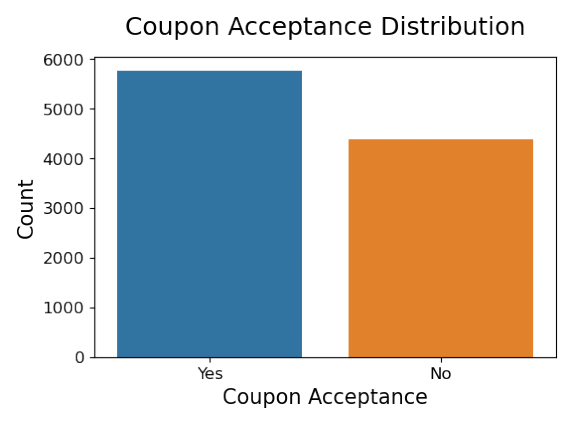

time: 93.4 ms (started: 2022-11-30 20:18:11 -08:00)


In [26]:
dpi=100
figure_filename = '../reports/figures/figure_target_variable_bar_plot_v3_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    #get Y_train data
    _, _, Y_train_plot, _ = train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)

    #get Y_train coupon accepted and not accepted count
    df_target_plot = Y_train_plot.replace({0:'No', 1:'Yes'}).value_counts().to_frame().reset_index().rename(columns={'index':'accepted_not_accepted','Y':'count'})

    axes_object = sns.barplot(data=df_target_plot, x='accepted_not_accepted', y='count')
    axes_object.set_title('Coupon Acceptance Distribution', fontdict={'fontsize':18}, pad=16)
    #axes_object.set(xlabel='Coupon Acceptance', ylabel='Count')
    plt.xlabel('Coupon Acceptance', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.tick_params(labelsize=12)



    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)
    
plt.show()

In [27]:
#take top features and check for statistical significant between them by response, i.e. did accept or did not accept coupon.

top_feature = 'expiration_category_representative_numeric_encoding'

df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted = df.loc[df.loc[:, 'Y'] == 0, [top_feature] + ['Y']]
df_expiration_category_representative_numeric_encoding_Y_coupon_accepted = df.loc[df.loc[:, 'Y'] == 1, [top_feature] + ['Y']]

time: 6.44 ms (started: 2022-11-30 20:18:11 -08:00)


In [28]:
#Proportion Hypothesis Tests for Binary Data

#https://statisticsbyjim.com/hypothesis-testing/comparing-hypothesis-tests-data-types/

#2 Proportions test to compare two samples

#1 Proportion test example: comparison to a target

time: 223 µs (started: 2022-11-30 20:18:11 -08:00)


In [29]:
df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted.value_counts()

expiration_category_representative_numeric_encoding  Y
2                                                    0    2819
24                                                   0    2655
dtype: int64

time: 3.74 ms (started: 2022-11-30 20:18:11 -08:00)


In [30]:
df_expiration_category_representative_numeric_encoding_Y_coupon_accepted.value_counts()

expiration_category_representative_numeric_encoding  Y
24                                                   1    4436
2                                                    1    2774
dtype: int64

time: 3.83 ms (started: 2022-11-30 20:18:11 -08:00)


In [31]:
4436 / (4436 + 2774)

0.615256588072122

time: 1.05 ms (started: 2022-11-30 20:18:11 -08:00)


In [32]:
#of scenarios where the the coupon is accepted, 61.5% of the time, it's a 24hours til expiration 

time: 171 µs (started: 2022-11-30 20:18:11 -08:00)


/Users/pauljacob/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income', ylabel='count'>

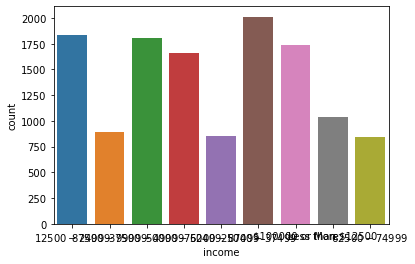

time: 281 ms (started: 2022-11-30 20:18:11 -08:00)


In [33]:
sns.countplot(df.loc[:, 'income'])

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabe

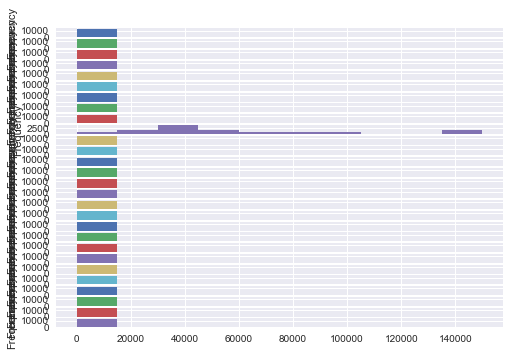

time: 1.48 s (started: 2022-11-30 20:18:11 -08:00)


In [34]:
plt.style.use('seaborn')

# Plotting as desired
df.plot.hist(subplots=True, legend=False)

In [35]:
#five types of coupons:
#bars
#takeaway food restaurants
#coffee houses
#cheap restaurants (average expense below $20 per person)
#expensive restaurants (average expense between $20 to $50 per person)

df.loc[:, 'coupon_venue_type'].value_counts()


Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: coupon_venue_type, dtype: int64

time: 5.25 ms (started: 2022-11-30 20:18:13 -08:00)


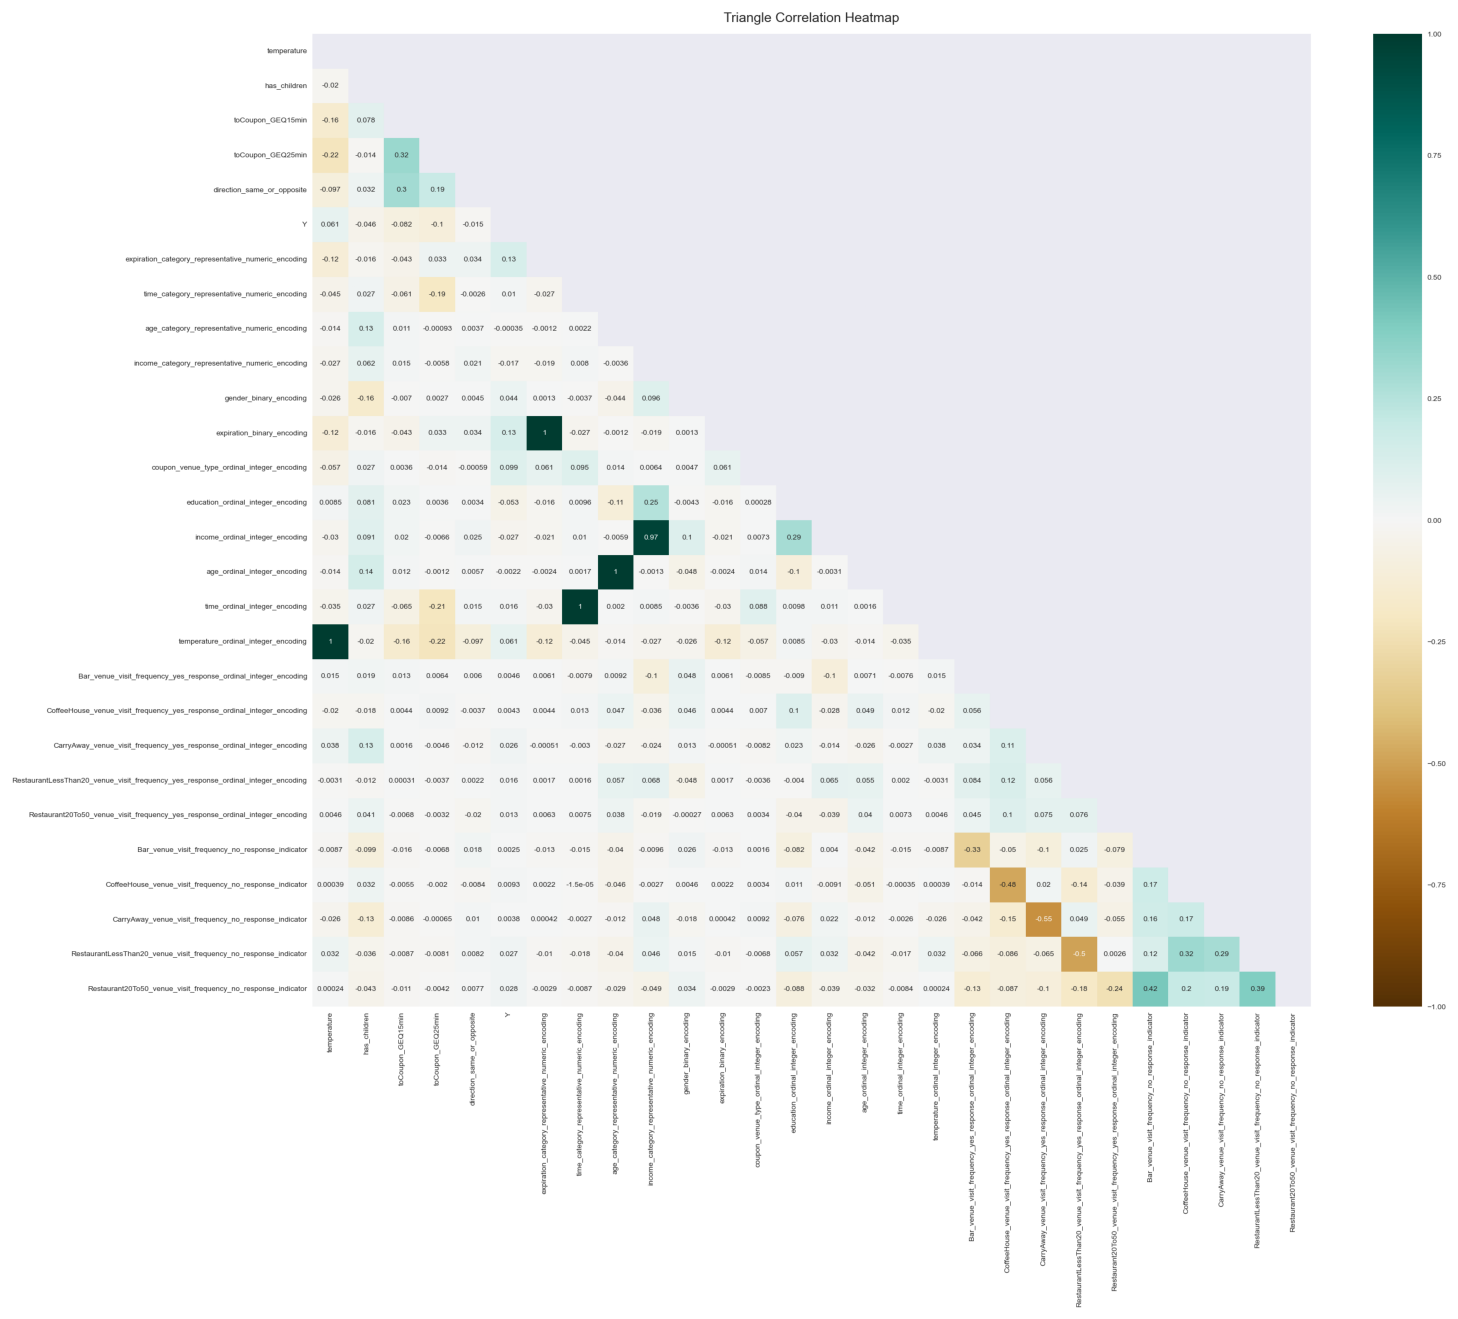

time: 679 ms (started: 2022-11-30 20:18:13 -08:00)


In [36]:
#correlation heatmap
dpi=100
figure_filename = '../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)

if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(30, 24))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    plt.figure(figsize=(30, 24))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [37]:
#^-----fix runtime here.

time: 143 µs (started: 2022-11-30 20:18:13 -08:00)


In [38]:
#.11 correlation between coupon acceptance and reported CoffeeHouse venue visit frequency

#.099 correlation between venue coupon type and coupon accpetance

#.13 correlation between coupon expiraton and coupon acceptance

#.07 correaltio between reported expensive restaurant visit frequency and coupon acceptance

#.07 correlation between coupon acceptance and reported bar visit frequency 

#.061 correlation between temperature and coupon acceptance

#-.1 correlation between coupon acceptance and driver travel time to venue is greater than 25 minute

#-.082 correlation between coupon acceptance and driver travel time to venue is greater than 15 minute

#-.046 correlation between having children and accpeting coupon

time: 339 µs (started: 2022-11-30 20:18:13 -08:00)


In [39]:
dir()

['Audio',
 'ConfusionMatrixDisplay',
 'GradientBoostingClassifier',
 'GridSearchCV',
 'In',
 'LogisticRegression',
 'Out',
 'RandomForestClassifier',
 'StandardScaler',
 'StratifiedKFold',
 '_',
 '_10',
 '_11',
 '_12',
 '_14',
 '_15',
 '_16',
 '_17',
 '_23',
 '_29',
 '_30',
 '_31',
 '_33',
 '_34',
 '_35',
 '_8',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'accuracy_score',
 'auc',
 'brier_score_loss',
 'classification_report',
 'column_name',
 'column_name_list',
 'column_name_list_scenario',
 'confusion_matr

time: 1.98 ms (started: 2022-11-30 20:18:13 -08:00)


In [40]:
# df_groups = pd.concat([data_frame_collection['X_train'].loc[:, 'coupon_venue_type_Bar'], data_frame_collection['Y_train'].loc[:, 'Y']], axis=1)
# p(df_groups)

time: 170 µs (started: 2022-11-30 20:18:13 -08:00)


In [41]:
# df_groups = pd.concat([data_frame_collection['X_train'].loc[:, 'coupon_venue_type_Bar'], data_frame_collection['Y_train'].loc[:, 'Y']], axis=1)
# p(df_groups)

time: 176 µs (started: 2022-11-30 20:18:13 -08:00)


In [42]:
#save preprocessed data frame
data_frame_version=filename_version
df_collection_filename='df_collection_train_test_v' + data_frame_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=df_collection_filename)
if df_readback != None:
    df_collection = df_readback
else:
    df_collection = {}
    
    #split the data into train and test
    df_collection['X_train'], df_collection['X_test'], df_collection['Y_train'], df_collection['Y_test'] = \
    train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)
    
    #save preprocessed data frame collection
    df_collection = icr.save_and_return_collection(data_frame_collection=df_collection, filename=df_collection_filename)

p(df_collection['X_train'])

This file already exists
(10147, 45)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
8630,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Female,21-25,Married partner,0,Bachelors degree,Unemployed,$87500 - $99999,no response,<1,never,4-8,never,never,0,0,1,24,18,23,93749.5,0,1,1,5,8,2,4,3,2,1,4,1,1,0,0,0,0,0
2418,No Urgent Place,Friend(s),Sunny,55,2PM,Coffee House,2h,Female,26-30,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$12500 - $24999,no response,>8,>8,>8,>8,never,0,0,1,2,14,28,18749.5,0,0,1,5,2,3,3,2,5,5,5,5,1,0,0,0,0,0
10804,No Urgent Place,Alone,Rainy,55,2PM,Carry out & Take away,2h,Female,31-35,Single,0,Graduate degree (Masters or Doctorate),Legal,$75000 - $87499,no response,no response,>8,>8,>8,>8,0,0,1,2,14,33,81249.5,0,0,3,6,7,4,3,2,0,5,5,5,5,1,0,0,0,0
747,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,36-40,Married partner,0,Some college - no degree,Healthcare Support,$25000 - $37499,no response,<1,<1,>8,>8,<1,1,0,1,24,14,38,31249.5,0,1,1,3,3,5,3,3,2,2,5,5,2,0,0,0,0,0
7333,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Male,<21,Unmarried partner,1,Some college - no degree,Building & Grounds Cleaning & Maintenance,$25000 - $37499,no response,<1,never,<1,<1,never,0,0,1,24,18,18,31249.5,1,1,1,3,3,1,4,3,2,1,2,2,1,0,0,0,0,0
10949,No Urgent Place,Kid(s),Snowy,30,6PM,Bar,1d,Female,31-35,Married partner,1,Bachelors degree,Student,$37500 - $49999,no response,1-3,never,no response,>8,never,0,0,1,24,18,33,43749.5,0,1,2,5,4,4,4,1,3,1,0,5,1,0,0,1,0,0
11937,No Urgent Place,Alone,Rainy,55,10AM,Bar,1d,Female,31-35,Married partner,0,Some college - no degree,Computer & Mathematical,$100000 or More,no response,never,never,no response,>8,never,1,0,1,24,10,33,150000.0,0,1,2,3,9,4,2,2,1,1,0,5,1,0,0,1,0,0
735,Home,Alone,Sunny,55,6PM,Restaurant(20-50),1d,Male,41-45,Single,0,Some college - no degree,Sales & Related,$37500 - $49999,no response,1-3,1-3,>8,<1,never,1,0,1,24,18,43,43749.5,1,1,5,3,4,6,4,2,3,3,5,2,1,0,0,0,0,0
67,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,46-49,Married partner,1,Bachelors degree,Education&Training&Library,$75000 - $87499,no response,never,<1,<1,<1,never,0,0,1,2,10,48,81249.5,1,0,1,5,7,7,2,3,1,2,2,2,1,0,0,0,0,0
3251,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,26-30,Married partner,1,Some college - no degree,Unemployed,$25000 - $37499,no response,1-3,never,<1,never,never,0,0,1,2,10,28,31249.5,0,0,1,3,3,3,2,3,3,1,2,1,1,0,0,0,0,0


time: 24.8 ms (started: 2022-11-30 20:18:13 -08:00)


## Get Stratified Train Data Frame Collection Before Data Preprocesssing

In [43]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(X=df_collection['X_train'], y=df_collection['Y_train'].to_frame())):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold ' + str(index)] = \
    {'X_train' : df_collection['X_train'].iloc[train_index, :], \
     'X_test' : df_collection['X_train'].iloc[test_index, :], \
     'Y_train' : df_collection['Y_train'].iloc[train_index], \
     'Y_test' : df_collection['Y_train'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold 0']['X_test'])



fold 0 TRAIN: [ 2028  2030  2031 ... 10144 10145 10146] TEST: [   0    1    2 ... 2027 2029 2032]
fold 1 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [2028 2030 2031 ... 4095 4101 4102]
fold 2 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [4009 4010 4012 ... 6131 6133 6135]
fold 3 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [6036 6037 6043 ... 8126 8127 8128]
fold 4 TRAIN: [   0    1    2 ... 8126 8127 8128] TEST: [ 8099  8105  8109 ... 10144 10145 10146]

(2030, 45)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
8630,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Female,21-25,Married partner,0,Bachelors degree,Unemployed,$87500 - $99999,no response,<1,never,4-8,never,never,0,0,1,24,18,23,93749.5,0,1,1,5,8,2,4,3,2,1,4,1,1,0,0,0,0,0
2418,No Urgent Place,Friend(s),Sunny,55,2PM,Coffee House,2h,Female,26-30,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$12500 - $24999,no response,>8,>8,>8,>8,never,0,0,1,2,14,28,18749.5,0,0,1,5,2,3,3,2,5,5,5,5,1,0,0,0,0,0
10804,No Urgent Place,Alone,Rainy,55,2PM,Carry out & Take away,2h,Female,31-35,Single,0,Graduate degree (Masters or Doctorate),Legal,$75000 - $87499,no response,no response,>8,>8,>8,>8,0,0,1,2,14,33,81249.5,0,0,3,6,7,4,3,2,0,5,5,5,5,1,0,0,0,0
747,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,36-40,Married partner,0,Some college - no degree,Healthcare Support,$25000 - $37499,no response,<1,<1,>8,>8,<1,1,0,1,24,14,38,31249.5,0,1,1,3,3,5,3,3,2,2,5,5,2,0,0,0,0,0
7333,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Male,<21,Unmarried partner,1,Some college - no degree,Building & Grounds Cleaning & Maintenance,$25000 - $37499,no response,<1,never,<1,<1,never,0,0,1,24,18,18,31249.5,1,1,1,3,3,1,4,3,2,1,2,2,1,0,0,0,0,0
1460,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Male,46-49,Married partner,1,Graduate degree (Masters or Doctorate),Management,$87500 - $99999,no response,never,<1,<1,never,<1,1,0,1,2,14,48,93749.5,1,0,1,6,8,7,3,3,1,2,2,1,2,0,0,0,0,0
8449,Work,Alone,Snowy,30,7AM,Restaurant(20-50),1d,Male,41-45,Married partner,1,Associates degree,Farming Fishing & Forestry,$25000 - $37499,no response,1-3,1-3,1-3,<1,1-3,1,1,1,24,7,43,31249.5,1,1,5,4,3,6,1,1,3,3,3,2,3,0,0,0,0,0
11224,Home,Alone,Rainy,55,10PM,Coffee House,2h,Male,50+,Unmarried partner,0,Some college - no degree,Student,$25000 - $37499,no response,1-3,1-3,<1,never,1-3,0,0,0,2,22,56,31249.5,1,0,1,3,3,8,5,2,3,3,2,1,3,0,0,0,0,0
5085,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(<20),2h,Male,26-30,Single,0,High School Graduate,Unemployed,$25000 - $37499,no response,never,<1,>8,<1,never,1,0,1,2,14,28,31249.5,1,0,4,2,3,3,3,3,1,2,5,2,1,0,0,0,0,0
7156,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(20-50),2h,Male,31-35,Married partner,1,Some college - no degree,Construction & Extraction,$37500 - $49999,no response,1-3,1-3,>8,>8,<1,1,0,1,2,14,33,43749.5,1,0,5,3,4,4,3,3,3,3,5,5,2,0,0,0,0,0


time: 35.4 ms (started: 2022-11-30 20:18:13 -08:00)


In [44]:
data_frame_list = [stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold ' + str(index)]['X_test'] for index in range(5)]

df_stratified_fold_number_X_test = pd.concat(data_frame_list)

p(df_stratified_fold_number_X_test)

(10147, 45)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
8630,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Female,21-25,Married partner,0,Bachelors degree,Unemployed,$87500 - $99999,no response,<1,never,4-8,never,never,0,0,1,24,18,23,93749.5,0,1,1,5,8,2,4,3,2,1,4,1,1,0,0,0,0,0
2418,No Urgent Place,Friend(s),Sunny,55,2PM,Coffee House,2h,Female,26-30,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$12500 - $24999,no response,>8,>8,>8,>8,never,0,0,1,2,14,28,18749.5,0,0,1,5,2,3,3,2,5,5,5,5,1,0,0,0,0,0
10804,No Urgent Place,Alone,Rainy,55,2PM,Carry out & Take away,2h,Female,31-35,Single,0,Graduate degree (Masters or Doctorate),Legal,$75000 - $87499,no response,no response,>8,>8,>8,>8,0,0,1,2,14,33,81249.5,0,0,3,6,7,4,3,2,0,5,5,5,5,1,0,0,0,0
747,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,36-40,Married partner,0,Some college - no degree,Healthcare Support,$25000 - $37499,no response,<1,<1,>8,>8,<1,1,0,1,24,14,38,31249.5,0,1,1,3,3,5,3,3,2,2,5,5,2,0,0,0,0,0
7333,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Male,<21,Unmarried partner,1,Some college - no degree,Building & Grounds Cleaning & Maintenance,$25000 - $37499,no response,<1,never,<1,<1,never,0,0,1,24,18,18,31249.5,1,1,1,3,3,1,4,3,2,1,2,2,1,0,0,0,0,0
10949,No Urgent Place,Kid(s),Snowy,30,6PM,Bar,1d,Female,31-35,Married partner,1,Bachelors degree,Student,$37500 - $49999,no response,1-3,never,no response,>8,never,0,0,1,24,18,33,43749.5,0,1,2,5,4,4,4,1,3,1,0,5,1,0,0,1,0,0
11937,No Urgent Place,Alone,Rainy,55,10AM,Bar,1d,Female,31-35,Married partner,0,Some college - no degree,Computer & Mathematical,$100000 or More,no response,never,never,no response,>8,never,1,0,1,24,10,33,150000.0,0,1,2,3,9,4,2,2,1,1,0,5,1,0,0,1,0,0
735,Home,Alone,Sunny,55,6PM,Restaurant(20-50),1d,Male,41-45,Single,0,Some college - no degree,Sales & Related,$37500 - $49999,no response,1-3,1-3,>8,<1,never,1,0,1,24,18,43,43749.5,1,1,5,3,4,6,4,2,3,3,5,2,1,0,0,0,0,0
67,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,46-49,Married partner,1,Bachelors degree,Education&Training&Library,$75000 - $87499,no response,never,<1,<1,<1,never,0,0,1,2,10,48,81249.5,1,0,1,5,7,7,2,3,1,2,2,2,1,0,0,0,0,0
3251,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,26-30,Married partner,1,Some college - no degree,Unemployed,$25000 - $37499,no response,1-3,never,<1,never,never,0,0,1,2,10,28,31249.5,0,0,1,3,3,3,2,3,3,1,2,1,1,0,0,0,0,0


time: 19.2 ms (started: 2022-11-30 20:18:13 -08:00)


<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Preprocessing]'>**Data Preprocessing**</a> </font>

## Convert Indicator Variables from Categorical Variables And Add Back to Numeric Variables

In [45]:
#get column name lists
column_name_list_numeric = list(df.select_dtypes('number').columns)
column_name_list_not_numeric = [column_name for column_name in df.columns if not column_name in column_name_list_numeric]

#get categorical features, numeric features, and target data frame
df_categorical_features = df.loc[:, column_name_list_not_numeric]
df_numeric_features = df.loc[:, column_name_list_numeric].drop(columns='Y')
df_target = df.loc[:, ['Y']]

#get category indicators data frame from df_categorical_features
df_category_indicator_features = pd.get_dummies(df_categorical_features)

del df_categorical_features

#combine category indicator features and numeric features
df_indicator_numeric_features = pd.concat([df_category_indicator_features, df_numeric_features], axis=1)

del df_numeric_features, 

p(df_indicator_numeric_features)


(12684, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
11199,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0

time: 60.3 ms (started: 2022-11-30 20:18:13 -08:00)


## Standardize And Scale Variables

In [46]:
#standardize and scale feature data frame
standard_scaler = StandardScaler()
standardized_scaled_df_indicator_numeric_features_ndarray = standard_scaler.fit_transform(df_indicator_numeric_features)
df_indicator_numeric_features_standardized_scaled = pd.DataFrame(standardized_scaled_df_indicator_numeric_features_ndarray, columns=df_indicator_numeric_features.columns, index=df_indicator_numeric_features.index)

del df_indicator_numeric_features, standardized_scaled_df_indicator_numeric_features_ndarray, StandardScaler

p(df_indicator_numeric_features_standardized_scaled)

(12684, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
11199,1.708345,-0.990740,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,2.073755,-0.678192,-0.365116,-0.530538,-1.125982,1

time: 89.9 ms (started: 2022-11-30 20:18:13 -08:00)


In [47]:
p(df_target)

(12684, 1)


,Y
11199,1
1474,0
10836,1
4567,0
5658,1
11343,0
9036,0
11050,0
784,1
1818,0


time: 4.06 ms (started: 2022-11-30 20:18:14 -08:00)


## Convert To Data Frame Collection With Train and Test Features and Train and Test Target From Standardized and Scaled Features Data Frame

In [48]:
#save preprocessed data frame
data_frame_version=filename_version
data_frame_collection_filename='data_frame_collection_train_test_v' + data_frame_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    data_frame_collection = {}
    
    #split the data into train and test
    data_frame_collection['X_train'], data_frame_collection['X_test'], data_frame_collection['Y_train'], data_frame_collection['Y_test'] = \
    train_test_split(df_indicator_numeric_features_standardized_scaled, df_target, test_size=.2, random_state=200)
    
    #save preprocessed data frame collection
    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

del df_indicator_numeric_features_standardized_scaled

p(data_frame_collection['X_train'])

This file already exists
(10147, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
8630,-0.585362,1.009347,-0.576501,-1.165358,1.686999,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,1.474508,-0.365116,-0.530538,0.888114,-0.

time: 65.8 ms (started: 2022-11-30 20:18:14 -08:00)


In [49]:
p(data_frame_collection['Y_train'])

(10147, 1)


,Y
8630,1
2418,1
10804,0
747,1
7333,1
10949,0
11937,0
735,1
67,1
3251,1


time: 4.1 ms (started: 2022-11-30 20:18:14 -08:00)


In [50]:
print(data_frame_collection['X_train'].shape, data_frame_collection['X_test'].shape, data_frame_collection['Y_train'].shape, data_frame_collection['Y_test'].shape)


(10147, 140) (2537, 140) (10147, 1) (2537, 1)
time: 571 µs (started: 2022-11-30 20:18:14 -08:00)


In [51]:
#we know what typse of coupons and their frequency in the survey. What types of coupons will be used the most for targetting customers?
#what venue types are requesting the most coupons???

#should the venue coupon demand influence how we design our train test splits ml model????
#the survey is supposed to attempt to represent the population which is in-vehicle coupon acceptance??? or is this recommendation??


time: 304 µs (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation X_train, X_test, Y_train, Y_test Collection

In [52]:
#stratified 5-fold cross validation train-test data row selection

#Stratified 5-Fold object
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#get stratfied 5-fold data frame splits
stratified_fold_number_X_train_X_test_Y_train_Y_test_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)] = \
    {'X_train' : data_frame_collection['X_train'].iloc[train_index, :], \
     'X_test' : data_frame_collection['X_train'].iloc[test_index, :], \
     'Y_train' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[train_index], \
     'Y_test' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_train'])

fold 0 TRAIN: [ 2028  2030  2031 ... 10144 10145 10146] TEST: [   0    1    2 ... 2027 2029 2032]
fold 1 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [2028 2030 2031 ... 4095 4101 4102]
fold 2 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [4009 4010 4012 ... 6131 6133 6135]
fold 3 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [6036 6037 6043 ... 8126 8127 8128]
fold 4 TRAIN: [   0    1    2 ... 8126 8127 8128] TEST: [ 8099  8105  8109 ... 10144 10145 10146]

(8117, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
11981,-0.585362,1.009347,-0.576501,-1.165358,1.686999,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,2.139015,-0.433432,-0.433816,-0.584512,-0.576501,-0.434842,2.073755,-0.678192,-0.365116,-0.530538,-1.125982,1

time: 126 ms (started: 2022-11-30 20:18:14 -08:00)


In [53]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_train'])

(8117,)


11981    1
3996     1
1301     1
9720     0
752      0
10949    0
11937    0
735      1
67       1
3251     1
Name: Y, dtype: int64

time: 2.13 ms (started: 2022-11-30 20:18:14 -08:00)


In [54]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_test'])

(2030, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator
8630,-0.585362,1.009347,-0.576501,-1.165358,1.686999,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,1.474508,-0.365116,-0.530538,0.888114,-0.

time: 76.6 ms (started: 2022-11-30 20:18:14 -08:00)


In [55]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_test'])

(2030,)


8630     1
2418     1
10804    0
747      1
7333     1
1460     1
8449     1
11224    0
5085     0
7156     0
Name: Y, dtype: int64

time: 2.4 ms (started: 2022-11-30 20:18:14 -08:00)


## Covert to Y Train Data Frame from Y Test Data Frame Collection

In [56]:
#convert to y_actual data frame from y_actual data frame collection
data_frame_list_stratified_fold_number_Y_test = [stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['Y_test'] for fold_number in range(5)]

df_stratified_fold_number_y_test = pd.concat(data_frame_list_stratified_fold_number_Y_test, axis=0, join='outer', ignore_index=False, copy=True).to_frame()
p(df_stratified_fold_number_y_test)

(10147, 1)


,Y
8630,1
2418,1
10804,0
747,1
7333,1
10949,0
11937,0
735,1
67,1
3251,1


time: 4.83 ms (started: 2022-11-30 20:18:14 -08:00)


<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Modeling]'>**Modeling**</a> </font>

## Initialize Filename & Results Collection Variables

In [57]:
classifier_name_list = ['random_forest_classifier', 'gradient_boosting_classifier', 'logistic_regression_classifier']

#filename
grid_search_models_filename_collection={}
grid_search_models_local_optimum_filename_collection={}

model_filename_collection = {}
model_cross_validation_results_filename_collection = {}

cross_validation_model_collection_filename_collection = {}
model_cross_validation_prediction_probability_collection_filename_collection = {}
model_cross_validation_prediction_collection_filename_collection = {}

learning_curve_results_filename_collection = {}

for classifier_name in classifier_name_list:
    grid_search_models_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_v' + filename_version + '.pkl'
    grid_search_models_local_optimum_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_local_optimum_v' + filename_version + '.pkl'
    
    model_filename_collection[classifier_name]='best_stratified_5_fold_grid_search_cross_validation_'+ classifier_name + '_v' + filename_version + '.pkl'
    model_cross_validation_results_filename_collection[classifier_name]='best_' + classifier_name + '_stratified_5_fold_cross_validation_results_v' + filename_version + '.pkl'

    cross_validation_model_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_probability_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_probability_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_collection_v' + filename_version + '.pkl'
    
    learning_curve_results_filename_collection[classifier_name]='learning_curve_results_best_' + classifier_name + '_v' + filename_version + '.pkl'

random_forest_classifier_all_data_fit_filename = 'random_forest_classifier_all_data_fit_v' + filename_version + '.pkl'
    
model_version=filename_version

time: 1.25 ms (started: 2022-11-30 20:18:14 -08:00)


## Initialize Other Variables

In [58]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_probability_data_frame_collection = {}

#stratified_5_fold_cross_validation_model_classifier_decision_threshold_prediction_data_frame_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_data_frame_collection = {}

model_stratified_5_fold_cross_validation_results_collection = {}



time: 461 µs (started: 2022-11-30 20:18:14 -08:00)


<font size="5"><a id='[Modeling_1]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_1]'>**Modeling 1**</a> </font>

## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy

In [59]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation

    # Create the parameter grid based on the results of random search
    param_grid = {
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'criterion':['gini'],
        'max_depth': [3, 5, 10, 20, 25, None], #ba 3, past 25 is a lot (and can be left to whatever large max depth then); previously [5, 10, 20, 25, 30, 35, 40]
        'min_samples_split': [1, 10, 50, 100], #ba 1, 10, 50, 100; previously [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'bootstrap': [False ,True],
        'oob_score': [False],
        'n_jobs': [None],
        'warm_start':[False],
        'class_weight':[None],
        'ccp_alpha':[0.0],
        'max_samples':[None],
    }
    #min_samples_leaf can be used as an alternative to 'min_samples_split'
    
    #RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4,
                       #n_estimators=200, random_state=200)

    # Create a based model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, 
                                                                                           param_grid=param_grid, 
                                                                                           cv=StratifiedKFold_5_splits,
                                                                                           n_jobs=-1, 
                                                                                           verbose=0,
                                                                                           scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                         filename=grid_search_models_filename_collection['random_forest_classifier'])
    
    #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

stratified_5_fold_grid_search_cross_validation_random_forest_classifier

This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'ccp_alpha': [0.0],
                         'class_weight': [None], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1],
                         'min_samples_split': [1, 10, 50, 100],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [200], 'n_jobs': [None],
                         'oob_score': [False], 'warm_start': [False]})

time: 42.4 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy For Local Optimum

In [60]:
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation
    param_grid = {
        'bootstrap': [False ,True],
        'criterion':['gini'],
        'max_features':['auto'],
        'max_depth': [3, 5, 10, 20, 25, None], # lower numbers reduce growth
        'min_samples_split': [1, 5, 10, 15, 20], # higher numbers reduce growth
        'min_samples_leaf':[1],
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'warm_start':[False]
    }
    #min_samples_leaf can be used as an alternative to 'min_samples_split'

    
    # Create a base model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = GridSearchCV(estimator=random_forest_classifier, 
                                                                                                         param_grid=param_grid, 
                                                                                                         cv=StratifiedKFold_5_splits,
                                                                                                         n_jobs=-1, 
                                                                                                         verbose=0,
                                                                                                         scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum, 
                                                                                                                      filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])

del stratified_5_fold_grid_search_cross_validation_random_forest_classifier
stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum


This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 5, 10, 15, 20],
                         'n_estimators': [200], 'warm_start': [False]})

time: 48.1 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Best Random Forest Classifier by Accuracy

In [61]:
#get best random forest classifier
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['random_forest_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.build_datetime = datetime.datetime.now()    

    
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                              filename=model_filename_collection['random_forest_classifier'])
    
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier


This file already exists


RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                       n_estimators=200, random_state=200)

time: 45.2 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Collection

In [62]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = {}
    for index in range(5):

        #create random forest classifier
        random_forest_classifier=RandomForestClassifier(bootstrap=False, 
                                                        max_depth=None, 
                                                        min_samples_split=10, 
                                                        n_estimators=200,
                                                        min_samples_leaf=1,
                                                        max_features='auto',
                                                        criterion='gini',
                                                        warm_start='False',
                                                        random_state=200)

        #train random forest classifier and save random forest classifer per fold
        random_forest_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                     y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)] = random_forest_classifier


    #save stratified 5-fold cross validation random forest classifier collection
    stratified_5_fold_cross_validation_random_forest_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_random_forest_classifier_collection, 
                                                                                                       filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_collection


This file already exists


{'fold 0': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 1': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 2': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 3': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 4': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False')}

time: 149 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Collection

In [63]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold 0']


This file already exists


array([[0.25267063, 0.74732937],
       [0.30154563, 0.69845437],
       [0.53545238, 0.46454762],
       ...,
       [0.76710317, 0.23289683],
       [0.13454365, 0.86545635],
       [0.47143056, 0.52856944]])

time: 3.83 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Series

In [64]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])



(10147,)


0       0.747329
1       0.698454
2       0.464548
3       0.780046
4       0.703800
2024    0.255984
2025    0.609718
2026    0.648345
2027    0.883756
2028    0.614171
Name: 1, dtype: float64

time: 4.18 ms (started: 2022-11-30 20:18:14 -08:00)


In [65]:
import warnings
warnings.filterwarnings('ignore')

time: 321 µs (started: 2022-11-30 20:18:14 -08:00)


In [66]:
column_name_list = ['precision',
                    'accuracy',
                    'recall',
                    'f1_score',
                    'specificity',
                    'false_positive_rate',
                    'true_positives', 
                    'false_positives', 
                    'false_negatives', 
                    'true_negatives']
column_name_dictionary={index:column_name_list[index] for index in range(len(column_name_list))}
pdc(column_name_dictionary)

10


{0: 'precision',
 1: 'accuracy',
 2: 'recall',
 3: 'f1_score',
 4: 'specificity',
 5: 'false_positive_rate',
 6: 'true_positives',
 7: 'false_positives',
 8: 'false_negatives',
 9: 'true_negatives'}

time: 2.58 ms (started: 2022-11-30 20:18:14 -08:00)


In [67]:
#precision-recall curve is good

#precision tp graph (for sliding decision threshold)???

##############################################################################
#recall vs tp + fn (for difference decision thresholds)???

#recall vs tp (for difference decision thresholds)???

time: 264 µs (started: 2022-11-30 20:18:14 -08:00)


<font size="5"><a id='[Modeling_2]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_2]'>**Modeling 2**</a> </font>

## Get Gradient Boosting Classifier Stratified 5-Fold Grid Seach Cross Validation

In [68]:
#good split for gradient boosting classifier??? what does the learning curve say???

#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = models_readback
else:
    gradient_boosting_classifier = GradientBoostingClassifier(random_state=200)
    param_grid = {'loss' : ['log_loss', 'exponential'],
                  'learning_rate' : [0.01, 0.1, 1, 10, 100],
                  'n_estimators' : [5, 50, 250, 500],
                  'subsample' : [1.0],
                  'criterion' : ['friedman_mse', 'squared_error'],
                  'min_samples_split' : [2],
                  'min_samples_leaf' : [1],
                  'min_weight_fraction_leaf' : [0.0],
                  'max_depth' : [1, 3, 5, 7, 9, None],
                  'min_impurity_decrease' : [0.0],
                  'init' : [None],
                  'max_features' : [None],
                  'max_leaf_nodes' : [None],
                  'warm_start' : [False],
                  'n_iter_no_change' : [None],
                 }

    #https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = GridSearchCV(estimator=gradient_boosting_classifier, 
                                                                                               param_grid=param_grid, 
                                                                                               cv=StratifiedKFold_5_splits,
                                                                                               n_jobs=-1, 
                                                                                               verbose=0,
                                                                                               scoring=None,
                                                                                               pre_dispatch="2*n_jobs")

    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.fit(X=data_frame_collection['X_train'], 
                                                                                    y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                                    groups=None)


    #save it
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                             filename=grid_search_models_filename_collection['gradient_boosting_classifier'],
                                                                                                             add_compressed_file=False)
    
stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=200), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'init': [None],
                         'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': [None], 'max_leaf_nodes': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [5, 50, 250, 500],
                         'n_iter_no_change': [None], 'subsample': [1.0],
                         'warm_start': [False]})

time: 18 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Best Gradient Boosting Classifier by Score

In [69]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['gradient_boosting_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.build_datetime = datetime.datetime.now()    

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                                  filename=model_filename_collection['gradient_boosting_classifier'],
                                                                                                                  add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


This file already exists


GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                           max_depth=9, n_estimators=250, random_state=200)

time: 15.1 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Collection

In [70]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = {}
    for index in range(5):

        #create gradient boosting classifier
        gradient_boosting_classifier = GradientBoostingClassifier(criterion='squared_error',
                                                                  loss='exponential',
                                                                  learning_rate = 0.1, 
                                                                  max_depth = 9, 
                                                                  n_estimators = 250,
                                                                  random_state=200,
                                                                  subsample=1.0,
                                                                  min_samples_split=2,
                                                                  min_samples_leaf=1,
                                                                  min_weight_fraction_leaf=0.0,
                                                                  min_impurity_decrease=0.0,
                                                                  init=None,
                                                                  max_features=None,
                                                                  verbose=0,
                                                                  max_leaf_nodes=None,
                                                                  warm_start=False,
                                                                  n_iter_no_change=None)

        
        #train gradient boosting classifier and save gradient boosting classifer per fold
        gradient_boosting_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                         y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)] = gradient_boosting_classifier


    #save stratified 5-fold cross validation gradient boosting classifier collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_gradient_boosting_classifier_collection, 
                                                                                                           filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_collection


This file already exists


{'fold 0': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 1': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 2': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 3': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 4': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200)}

time: 55.6 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Collection

In [71]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction probability collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold 0']


This file already exists


array([[4.12933792e-01, 5.87066208e-01],
       [7.22266326e-02, 9.27773367e-01],
       [9.98396057e-01, 1.60394337e-03],
       ...,
       [9.99973299e-01, 2.67013049e-05],
       [1.30475773e-04, 9.99869524e-01],
       [1.02815481e-01, 8.97184519e-01]])

time: 3.94 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Data Frame

In [72]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])



(10147,)


0       0.587066
1       0.927773
2       0.001604
3       0.985565
4       0.938343
2024    0.131208
2025    0.847868
2026    0.991338
2027    0.999945
2028    0.947660
Name: 1, dtype: float64

time: 4.08 ms (started: 2022-11-30 20:18:14 -08:00)


## Gradient Boosting Classifier Stratified 5-Fold Cross Validation Prediction Collection

In [73]:
prediction_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_collection_filename_collection['gradient_boosting_classifier'])
if prediction_ndarray_collection != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection = prediction_ndarray_collection
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)]\
        .predict(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    
    #save stratified 5-fold cross validation gradient boosting classifier prediction collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection, 
                                                                                                                           filename=model_cross_validation_prediction_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection['fold 0']


This file already exists


array([1, 1, 0, ..., 0, 1, 1])

time: 3.36 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Data Frame

In [74]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])



(10147,)


0       0.587066
1       0.927773
2       0.001604
3       0.985565
4       0.938343
2024    0.131208
2025    0.847868
2026    0.991338
2027    0.999945
2028    0.947660
Name: 1, dtype: float64

time: 3.75 ms (started: 2022-11-30 20:18:14 -08:00)


<font size="5"><a id='[Modeling_3]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_3]'>**Modeling 3**</a> </font>

## Get Logistic Regression Classifier Stratified 5-Fold Grid Search Cross Validation

In [75]:
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['logistic_regression_classifier'],)
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier = models_readback
else:
    param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
                  'dual': [False],
                  'tol':[1e-4],
                  'C':[1.0],
                  'fit_intercept':[True],
                  'intercept_scaling':[1],
                  'class_weight':['balanced', None],
                  'random_state':[None],
                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'max_iter':[1, 10, 100, 1000],
                  'multi_class':['auto'],
                  'verbose':[0],
                  'warm_start':[False],
                  'n_jobs':[None],
                  'l1_ratio':[.3, .6, None],}

    logistic_regression_classifier = LogisticRegression(random_state=200)

    
    stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier = GridSearchCV(estimator=logistic_regression_classifier,
                                                                                                 param_grid=param_grid,
                                                                                                 refit=True,
                                                                                                 cv=StratifiedKFold_5_splits,
                                                                                                 verbose=3)

    # fitting the model for grid search
    stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'])
    
    stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier = icr.save_and_return_model(model=stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier,
                                                                                                              filename=grid_search_models_filename_collection['logistic_regression_classifier'])

stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier

This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=200),
             param_grid={'C': [1.0], 'class_weight': ['balanced', None],
                         'dual': [False], 'fit_intercept': [True],
                         'intercept_scaling': [1], 'l1_ratio': [0.3, 0.6, None],
                         'max_iter': [1, 10, 100, 1000],
                         'multi_class': ['auto'], 'n_jobs': [None],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'random_state': [None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.0001], 'verbose': [0],
                         'warm_start': [False]},
             verbose=3)

time: 6.94 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Best Stratified 5-Fold Logistic Regression Classifier

In [76]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['logistic_regression_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier = stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier.build_datetime = datetime.datetime.now()    

    
    best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier, 
                                                                                                                   filename=model_filename_collection['logistic_regression_classifier'],
                                                                                                                   add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_logistic_regression_classifier


This file already exists


LogisticRegression(l1_ratio=0.3, max_iter=10, solver='sag')

time: 3 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Logistic Regression Classifier Collection

In [77]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['logistic_regression_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_logistic_regression_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_logistic_regression_classifier_collection = {}
    for index in range(5):

        #create logistic regression classifier
        logistic_regression_classifier=LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', solver='sag', random_state=200)
        

        
        #train logistic regression classifier and save logistic regression classifer per fold
        logistic_regression_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                           y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_logistic_regression_classifier_collection['fold ' + str(index)] = logistic_regression_classifier


    #save stratified 5-fold cross validation logistic regression classifier collection
    stratified_5_fold_cross_validation_logistic_regression_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_logistic_regression_classifier_collection, 
                                                                                                           filename=cross_validation_model_collection_filename_collection['logistic_regression_classifier'])
stratified_5_fold_cross_validation_logistic_regression_classifier_collection


This file already exists


{'fold 0': LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', random_state=200,
                    solver='sag'),
 'fold 1': LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', random_state=200,
                    solver='sag'),
 'fold 2': LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', random_state=200,
                    solver='sag'),
 'fold 3': LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', random_state=200,
                    solver='sag'),
 'fold 4': LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', random_state=200,
                    solver='sag')}

time: 4.63 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Logistic Regression Classifier Prediction Probability Collection

In [78]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['logistic_regression_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_logistic_regression_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction probability collection
    stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection, 
                                                                                                                                         filename=model_cross_validation_prediction_probability_collection_filename_collection['logistic_regression_classifier'])
stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection['fold 0']



This file already exists


array([[0.17549101, 0.82450899],
       [0.45472068, 0.54527932],
       [0.39217872, 0.60782128],
       ...,
       [0.8323084 , 0.1676916 ],
       [0.1427575 , 0.8572425 ],
       [0.43256682, 0.56743318]])

time: 3.8 ms (started: 2022-11-30 20:18:14 -08:00)


## Get Stratified 5-Fold Cross Validation Logistic Regression Classifier Prediction Probability Data Frame

In [79]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['logistic_regression_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_logistic_regression_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['logistic_regression_classifier'])



(10147,)


0       0.824509
1       0.545279
2       0.607821
3       0.864931
4       0.816087
2024    0.275689
2025    0.389132
2026    0.409123
2027    0.569350
2028    0.484505
Name: 1, dtype: float64

time: 3.71 ms (started: 2022-11-30 20:18:14 -08:00)


<font size="5"><a id='[Modeling_Train_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_Train_Results]'>**Modeling Train Results**</a> </font>

# Learning Curve for Random Forest, Gradient Boosting, and Logistic Regression Classifier

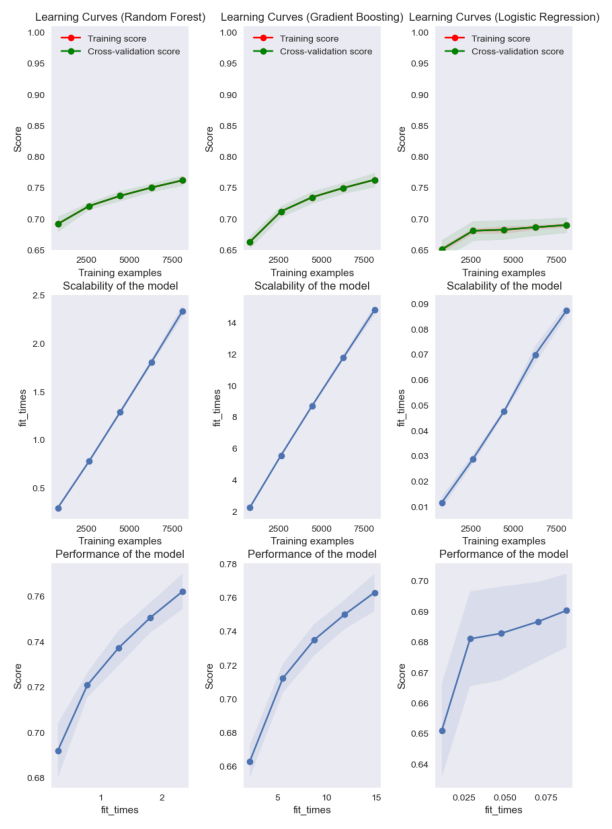

time: 153 ms (started: 2022-11-30 20:18:14 -08:00)


In [80]:
dpi=100
figure_filename = '../reports/figures/figure_train_size_score_random_forest_classifier_gradient_boosting_classifier_logistic_regression_classifier_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(60, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:    
    fig, axes = plt.subplots(3, 3, figsize=(10, 15))

    title = "Learning Curves (Random Forest)"

    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    estimator = RandomForestClassifier(bootstrap=False, 
                                       max_depth=25, 
                                       min_samples_split=4, 
                                       n_estimators=200,
                                       random_state=200,
                                       min_samples_leaf=1,
                                       max_features='auto',
                                       criterion='gini',
                                       warm_start='False',)

    plt, learning_curve_random_forest_classifier = icr.plot_learning_curve(estimator, 
                                                                           title, 
                                                                           X=data_frame_collection['X_train'], 
                                                                           y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                           filename=learning_curve_results_filename_collection['random_forest_classifier'],
                                                                           axes=axes[:, 0], 
                                                                           ylim=(0.65, 1.01), 
                                                                           cv=cv, 
                                                                           n_jobs=4, 
                                                                           scoring="accuracy")


    title = r"Learning Curves (Gradient Boosting)"

    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                           max_depth = 9, 
                                           n_estimators = 250,
                                           random_state=200,
                                           max_features=None,
                                           verbose=0,
                                           max_leaf_nodes=None,
                                           warm_start=False,
                                           n_iter_no_change=None)

    plt, learning_curve_gradient_boosting_classifier = icr.plot_learning_curve(estimator, 
                                                                               title, 
                                                                               X=data_frame_collection['X_train'], 
                                                                               y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                               filename=learning_curve_results_filename_collection['gradient_boosting_classifier'],
                                                                               axes=axes[:, 1], 
                                                                               ylim=(0.65, 1.01), 
                                                                               cv=cv, 
                                                                               n_jobs=4)
    
    
    title = "Learning Curves (Logistic Regression)"

    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    estimator = LogisticRegression(l1_ratio=0.6, max_iter=10, penalty='none', solver='sag', random_state=200)

    plt, learning_curve_random_forest_classifier = icr.plot_learning_curve(estimator, 
                                                                           title, 
                                                                           X=data_frame_collection['X_train'], 
                                                                           y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                           filename=learning_curve_results_filename_collection['logistic_regression_classifier'],
                                                                           axes=axes[:, 2], 
                                                                           ylim=(0.65, 1.01), 
                                                                           cv=cv, 
                                                                           n_jobs=4, 
                                                                           scoring="accuracy")
    fig.subplots_adjust(wspace=.4)

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

del StratifiedKFold

plt.show()

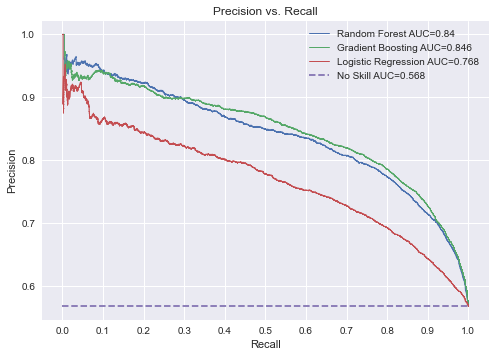

time: 224 ms (started: 2022-11-30 20:18:15 -08:00)


In [81]:
filename = '../reports/figures/figure_precision_recall_curve_random_forest_gradient_boosting_logistic_regression_metric_auc_v' + filename_version + '.png'
markersize=1
linewidth=1

#calculate precision-recall points
random_forest_classifier_precision_array, random_forest_classifier_recall_array, random_forest_classifier_threshold_array = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])
#calculate precision-recall curve auc
random_forest_classifier_auc = auc(random_forest_classifier_recall_array, random_forest_classifier_precision_array)

# plot the precision-recall curve
plt.plot(random_forest_classifier_recall_array, random_forest_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Random Forest AUC=' + str(round(random_forest_classifier_auc, 3)))




#calculate precision-recall points
gradient_boosting_classifier_precision_array, gradient_boosting_classifier_recall_array, gradient_boosting_classifier_threshold_array = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])
#calculate precision-recall curve auc
gradient_boosting_classifier_auc = auc(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array)

# plot the precision-recall curve
plt.plot(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Gradient Boosting AUC=' + str(round(gradient_boosting_classifier_auc, 3)))




#calculate precision-recall points
logistic_regression_classifier_precision_array, logistic_regression_classifier_recall_array, _ = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['logistic_regression_classifier'])

#calculate precision-recall curve auc
logistic_regression_classifier_auc = auc(logistic_regression_classifier_recall_array, logistic_regression_classifier_precision_array)

# plot the precision-recall curve
plt.plot(logistic_regression_classifier_recall_array, logistic_regression_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Logistic Regression AUC=' + str(round(logistic_regression_classifier_auc, 3)))





#calculate no skill classifier curve
no_skill_classifier_auc = data_frame_collection['Y_train'].loc[data_frame_collection['Y_train'].loc[:, 'Y']==1, 'Y'].shape[0] / data_frame_collection['Y_train'].loc[:, 'Y'].shape[0]
plt.plot([0, 1], [no_skill_classifier_auc, no_skill_classifier_auc], linestyle='--', label='No Skill AUC='+str(round(no_skill_classifier_auc, 3)))

plt.xticks([.0, .1 ,.2, .3 ,.4, .5, .6 ,.7, .8, .9, 1 ])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.legend()


#save it
plt.savefig(filename, bbox_inches='tight', dpi=100)

plt.show()


#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


In [82]:
#get random forest data frame of decision threshold, precision, and recall
random_forest_classifier_threshold_array = np.append(0, random_forest_classifier_threshold_array)

df_random_forest_decision_threshold_precision_recall = pd.DataFrame({'random_forest_decision_threshold':random_forest_classifier_threshold_array, 'random_forest_precision':random_forest_classifier_precision_array, 'random_forest_recall':random_forest_classifier_recall_array})
del random_forest_classifier_threshold_array
p(df_random_forest_decision_threshold_precision_recall)


(10077, 3)


,random_forest_decision_threshold,random_forest_precision,random_forest_recall
0,0.000000,0.569438,1.000000
1,0.068534,0.569395,0.999826
2,0.068754,0.569451,0.999826
3,0.069171,0.569508,0.999826
4,0.069347,0.569564,0.999826
10072,0.979371,1.000000,0.000694
10073,0.981250,1.000000,0.000521
10074,0.981542,1.000000,0.000347
10075,0.982002,1.000000,0.000174
10076,0.982663,1.000000,0.000000


time: 4.92 ms (started: 2022-11-30 20:18:15 -08:00)


In [83]:
#get gradient boosting data frame of decision threshold, precision, and recall
gradient_boosting_classifier_threshold_array = np.append(0, gradient_boosting_classifier_threshold_array)

df_gradient_boosting_decision_threshold_precision_recall = pd.DataFrame({'gradient_boosting_decision_threshold':gradient_boosting_classifier_threshold_array, 'gradient_boosting_precision':gradient_boosting_classifier_precision_array, 'gradient_boosting_recall':gradient_boosting_classifier_recall_array})
del gradient_boosting_classifier_threshold_array
p(df_gradient_boosting_decision_threshold_precision_recall)


(10124, 3)


,gradient_boosting_decision_threshold,gradient_boosting_precision,gradient_boosting_recall
0,0.000000,0.568595,1.000000
1,0.000002,0.568552,0.999826
2,0.000002,0.568608,0.999826
3,0.000002,0.568664,0.999826
4,0.000002,0.568720,0.999826
10119,1.000000,1.000000,0.000694
10120,1.000000,1.000000,0.000521
10121,1.000000,1.000000,0.000347
10122,1.000000,1.000000,0.000174
10123,1.000000,1.000000,0.000000


time: 5.31 ms (started: 2022-11-30 20:18:15 -08:00)


## Get Model Precision .9 and  Recall .8 Decision Threshold by Coupon Venue Type

### Get Data Frame Y Actual, Y Random Forest Prediction Probability, Y Gradient Boosting Prediction Probability Collection by Coupon Venue Type

In [84]:
# Get Coupon Venue Type, Random Forest Prediction Probability, Gradient Boosting Prediction Probability, and Y Actual
data_frame_list = [df_stratified_fold_number_y_test.reset_index(drop=True), 
                   stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'].to_frame().rename(columns={1:'Y_random_forest_prediction_probability'}).reset_index(drop=True),
                   stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'].to_frame().rename(columns={1:'Y_gradient_boosting_prediction_probability'}).reset_index(drop=True),
                   df_stratified_fold_number_X_test.loc[:, 'coupon_venue_type'].reset_index(drop=True)]

df_y_train_prediction_probability_coupon_venue_type = pd.concat(data_frame_list, axis=1)

#get data frame collection by coupon venue type
coupon_venue_type_list = df_y_train_prediction_probability_coupon_venue_type.loc[:, 'coupon_venue_type'].drop_duplicates().to_list()

df_y_train_prediction_probability_coupon_venue_type_collection = {coupon_venue_type: df_y_train_prediction_probability_coupon_venue_type.loc[df_y_train_prediction_probability_coupon_venue_type.loc[:, 'coupon_venue_type']== coupon_venue_type,:] for coupon_venue_type in coupon_venue_type_list}

p(df_y_train_prediction_probability_coupon_venue_type_collection['Coffee House'])



(3185, 4)


,Y,Y_random_forest_prediction_probability,Y_gradient_boosting_prediction_probability,coupon_venue_type
0,1,0.747329,0.587066,Coffee House
1,1,0.698454,0.927773,Coffee House
3,1,0.780046,0.985565,Coffee House
4,1,0.703800,0.938343,Coffee House
5,0,0.594214,0.692802,Coffee House
10129,1,0.452407,0.245842,Coffee House
10130,0,0.354153,0.022894,Coffee House
10132,1,0.552071,0.868979,Coffee House
10145,1,0.883756,0.999945,Coffee House
10146,1,0.614171,0.947660,Coffee House


time: 13.7 ms (started: 2022-11-30 20:18:15 -08:00)


### Model Precision-Recall Curve for Coffee Coupon

In [85]:
decision_threshold_collection = {}

time: 222 µs (started: 2022-11-30 20:18:15 -08:00)


row count: 3185
Random Forest Coffee House Coupon .9 precision 
decision thresholds [0.7580674603174602, 0.7581170634920632, 0.7583293650793652, 0.7587400793650794, 0.7593015873015869, 0.7599186507936507, 0.7606448412698412, 0.7608591269841266, 0.764174603174603, 0.7645615079365079, 0.7649563492063494, 0.7651646825396827, 0.7654662698412699, 0.7659623015873016, 0.7659900793650791, 0.7665853174603172, 0.766861111111111, 0.7669583333333331, 0.7670317460317456, 0.7670555555555555, 0.7673432539682535, 0.767406746031746, 0.7675178571428574, 0.7676984126984128, 0.7677956349206344, 0.7681388888888887]

Random Forest Coffee House Coupon .8 recall 
decision thresholds [0.48577777777777753]

Gradient Boosting Coffee House Coupon .9 precision 
decision thresholds [0.9951461183487912, 0.9952487710112122, 0.9952931190255159, 0.995301875516557, 0.9953269416226073, 0.9956599770127567, 0.9957645680279684, 0.9957826856242064, 0.9957968816720534, 0.9958042837684937, 0.9959049723061618, 0.995909284760570

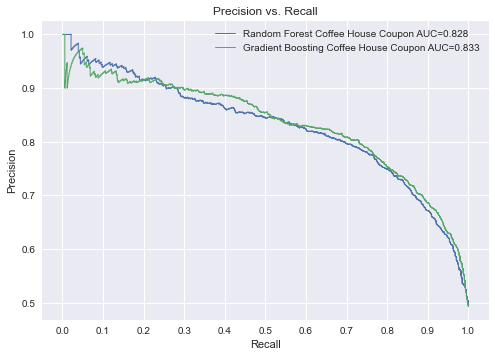

time: 94.5 ms (started: 2022-11-30 20:18:15 -08:00)


In [86]:
icr.precision_recall_auc_plots(df_collection=df_y_train_prediction_probability_coupon_venue_type_collection,
                               coupon_venue_type='Coffee House',
                               precision_lower_upper=[.899, .901],
                               recall_lower_upper=[.79999, .801])
decision_threshold_collection.update({'Coffee House':{'gradient_boosting_precision':0.7580674603174602, 'gradient_boosting_recall':0.37466044195068726}})


### Model Precision-Recall Curve for Bar Coupon

row count: 1618
Random Forest Bar Coupon .9 precision 
decision thresholds [0.7456111111111112, 0.7622559523809522, 0.771313492063492, 0.779876984126984]

Random Forest Bar Coupon .8 recall 
decision thresholds [0.4231309523809524]

Gradient Boosting Bar Coupon .9 precision 
decision thresholds [0.9999783486836313]

Gradient Boosting Bar Coupon .8 recall 
decision thresholds [0.13379544334169902]



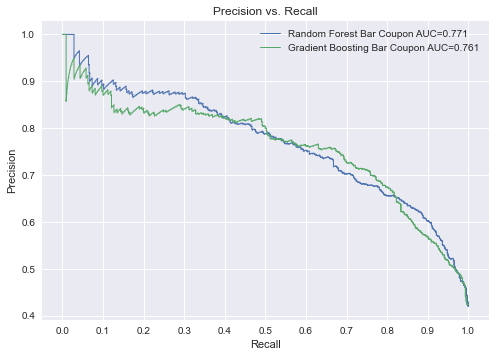

time: 97.2 ms (started: 2022-11-30 20:18:15 -08:00)


In [87]:
icr.precision_recall_auc_plots(df_collection=df_y_train_prediction_probability_coupon_venue_type_collection,
                               coupon_venue_type='Bar',
                               precision_lower_upper=[.899, .901],
                               recall_lower_upper=[.799999, .801])

decision_threshold_collection.update({'Bar':{'random_forest_precision':0.7456111111111112, 'gradient_boosting_recall':0.13379544334169902}})

### Model Precision-Recall Curve for Takeout Coupon

row count: 1904
Random Forest Carry out & Take away Coupon .9 precision 
decision thresholds [0.8246071428571429, 0.8251408730158728, 0.825404761904762]

Random Forest Carry out & Take away Coupon .8 recall 
decision thresholds [0.6508888888888891]

Gradient Boosting Carry out & Take away Coupon .9 precision 
decision thresholds [0.9974378590331576, 0.9975020114274846, 0.9975241799705501, 0.9975338982683242, 0.9975346706519324, 0.9975596068604126, 0.9976029192454339, 0.9976285591244931, 0.9976423154895858, 0.9976535681579239, 0.997655464316996, 0.9976694536081205, 0.9976752776428793, 0.9977335006065142, 0.9977353914395722, 0.9977383137488673, 0.9977419352926448, 0.9977487092022774, 0.9999950379865535]

Gradient Boosting Carry out & Take away Coupon .8 recall 
decision thresholds [0.8854508405619727]



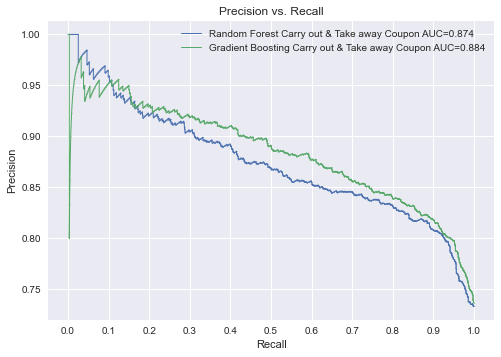

time: 91.4 ms (started: 2022-11-30 20:18:15 -08:00)


In [88]:
icr.precision_recall_auc_plots(df_collection=df_y_train_prediction_probability_coupon_venue_type_collection,
                               coupon_venue_type='Carry out & Take away',
                               precision_lower_upper=[.899999, .901],
                               recall_lower_upper=[.79999, .801])

decision_threshold_collection.update({'Carry out & Take away':{'gradient_boosting_precision':0.9974378590331576, 'gradient_boosting_recall':0.8854508405619727}})


### Model Precision-Recall Curve for Inexpensive Restaurant Coupon

row count: 2252
Random Forest Restaurant(<20) Coupon .9 precision 
decision thresholds [0.7747638888888889, 0.7750456349206347, 0.7750654761904763, 0.7751051587301587, 0.7754464285714286, 0.7756825396825395, 0.7757559523809523, 0.7759424603174603, 0.7771448412698413, 0.7773253968253968, 0.7773809523809523, 0.7775615079365075]

Random Forest Restaurant(<20) Coupon .8 recall 
decision thresholds [0.6512658730158729, 0.6518630952380953, 0.6521071428571429]

Gradient Boosting Restaurant(<20) Coupon .9 precision 
decision thresholds [0.9854502364161667, 0.9881085559543317, 0.9881210160773701, 0.9881515469639549, 0.988213464393302, 0.9891426540934446, 0.9892133309336615, 0.9892803961430584, 0.9893498052624267, 0.989376382319811, 0.9894359402391328, 0.9894562655280458, 0.9895616259252541, 0.9897054866591337, 0.9897640688310755, 0.9897680341351776, 0.9898078359433362, 0.9900791390437343, 0.9901293541344707, 0.9902529723504592]

Gradient Boosting Restaurant(<20) Coupon .8 recall 
decision thres

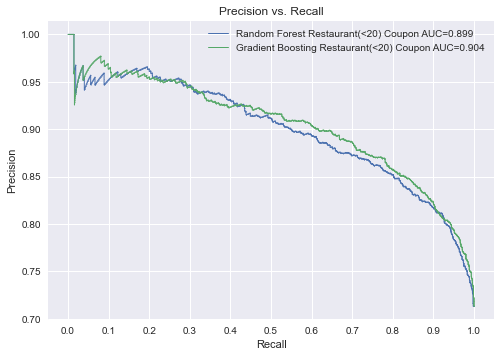

time: 98.8 ms (started: 2022-11-30 20:18:15 -08:00)


In [89]:
icr.precision_recall_auc_plots(df_collection=df_y_train_prediction_probability_coupon_venue_type_collection,
                               coupon_venue_type='Restaurant(<20)',
                               precision_lower_upper=[.899, .901],
                               recall_lower_upper=[.79999, .801])

decision_threshold_collection.update({'Restaurant(<20)':{'gradient_boosting_precision':0.9854502364161667, 'gradient_boosting_recall':0.9015847192478904}})


### Model Precision-Recall Curve by Expensive Restaurant Coupon

row count: 1188
Random Forest Restaurant(20-50) Coupon .9 precision 
decision thresholds [0.7898095238095234]

Random Forest Restaurant(20-50) Coupon .8 recall 
decision thresholds [0.4123730158730159, 0.4126190476190477, 0.41277579365079364]

Gradient Boosting Restaurant(20-50) Coupon .9 precision 
decision thresholds [0.9996838085015485, 0.9998191614451433, 0.9998997903559125]

Gradient Boosting Restaurant(20-50) Coupon .8 recall 
decision thresholds [0.09031483338266143]



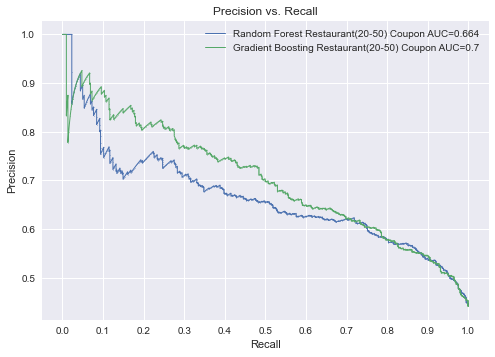

time: 90.4 ms (started: 2022-11-30 20:18:15 -08:00)


In [90]:
icr.precision_recall_auc_plots(df_collection=df_y_train_prediction_probability_coupon_venue_type_collection,
                               coupon_venue_type='Restaurant(20-50)',
                               precision_lower_upper=[.899, .901],
                               recall_lower_upper=[.799, .801])

decision_threshold_collection.update({'Restaurant(20-50)':{'gradient_boosting_precision':0.9996838085015485, 'gradient_boosting_recall':0.09031483338266143}})

In [91]:
#baseline for classification problem???

#for varying percentage of total number of coupon recommendation opportunities, ???

time: 193 µs (started: 2022-11-30 20:18:15 -08:00)


## Get Baseline Confusion Matrix

baseline_precision: 0.5696556546058381
baseline_recall: 0.5657003992362437
baseline_accuracy: 0.5107913669064749
tn: 1924
fp: 2462
fn: 2502
tp: 3259
Of 5721 coupon recommendations 3259 accepted the coupon saying they would use it. This is a potential 56.97% conversion rate and a potential 3259 total customer acquisitions.


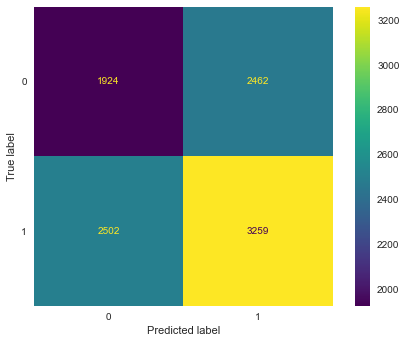

time: 94.7 ms (started: 2022-11-30 20:18:15 -08:00)


In [92]:
number_of_predictions = data_frame_collection['Y_train'].shape[0]

y_true=data_frame_collection['Y_train']

np.random.seed(200)
#y_pred=np.random.randint(2, size=number_of_predictions)#no adjustment needed, just a baseline example application
class_0_probability = data_frame_collection['Y_train'].value_counts()[0] / data_frame_collection['Y_train'].shape[0]
class_1_probability = data_frame_collection['Y_train'].value_counts()[1] / data_frame_collection['Y_train'].shape[0]
y_pred=np.random.choice([0, 1], size=number_of_predictions, p=[class_0_probability, class_1_probability])

#altnerative to assigning 0 and 1 in train class ratio, which is not respecting the train test structure of not knowing the y_test outcomes per cross validation.

#so the way to fix this is to get the 0 to 1 ratio of the 4 folds that would be used to generate 0s and 1s to predict on the held out test fold?


baseline_precision = precision_score(y_true, y_pred)
baseline_recall = recall_score(y_true, y_pred)
baseline_accuracy = accuracy_score(y_true, y_pred)

print('baseline_precision: '+ str(baseline_precision))
print('baseline_recall: ' + str(baseline_recall))
print('baseline_accuracy: ' + str(baseline_accuracy))

confusion_matrix_ndarray = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix_ndarray.ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

print('Of ' + str(tp + fp) + ' coupon recommendations ' + str(tp) + ' accepted the coupon saying they would use it. \
This is a potential ' + str(round(baseline_precision*100, 2)) + '% conversion rate and a potential ' + str(3259) + ' total customer acquisitions.') 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ndarray, display_labels=[0,1])
disp.plot()
plt.grid(False)

plt.show()

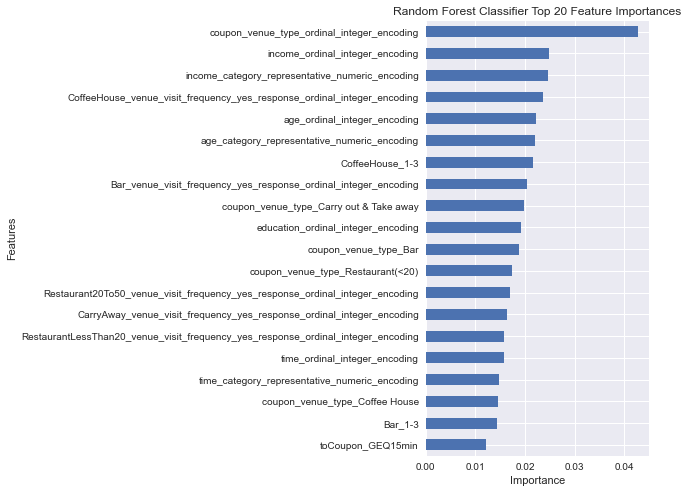

time: 282 ms (started: 2022-11-30 20:18:15 -08:00)


In [93]:
#get feature importants plot
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_20_feature_importances_v' + filename_version + '.png'

plt.subplots(figsize=(4, 8))

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:20].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top 20 Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)



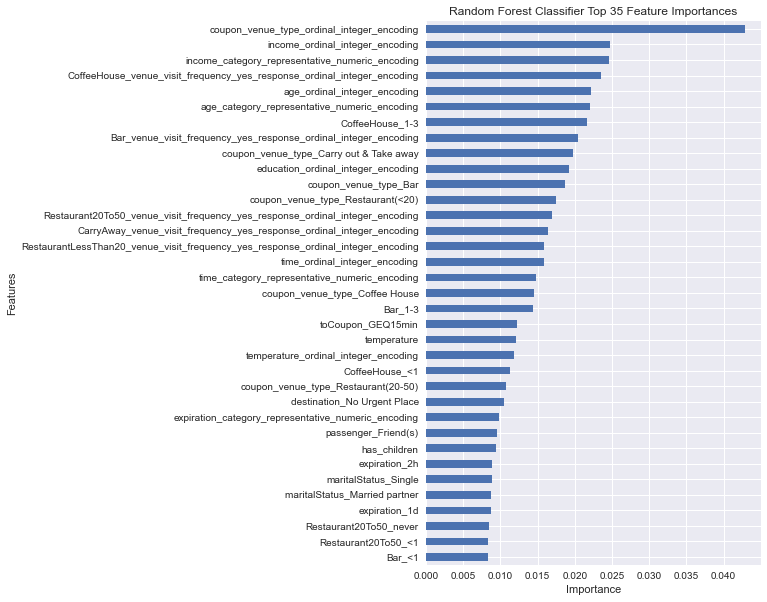

time: 410 ms (started: 2022-11-30 20:18:16 -08:00)


In [94]:
#get feature importants plot
top_number_features = 35
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_'+ str(top_number_features) +'_feature_importances_v' + filename_version + '.png'

top_number_features = 35

plt.subplots(figsize=(6, 10))

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:top_number_features].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top ' + str(top_number_features)   + ' Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)



In [95]:
column_name_list_random_forest_classifier_top_50_by_feature_importance = series_random_forest_classifier_feature_importances[0:50].index.to_list()

column_name_list_random_forest_classifier_top_25_by_feature_importance = series_random_forest_classifier_feature_importances[0:25].index.to_list()

pl(column_name_list_random_forest_classifier_top_50_by_feature_importance)

50


['coupon_venue_type_ordinal_integer_encoding',
 'income_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'CoffeeHouse_1-3',
 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Carry out & Take away',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Restaurant(<20)',
 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'Bar_1-3',
 'toCoupon_GEQ15min',
 'temperature',
 'temperature_ordinal_integer_encoding',
 'CoffeeHouse_<1',
 'c

time: 2.3 ms (started: 2022-11-30 20:18:16 -08:00)


In [96]:
column_name_list_random_forest_classifier_top_50_by_feature_importance_target = column_name_list_random_forest_classifier_top_50_by_feature_importance + ['Y']
column_name_list_random_forest_classifier_top_25_by_feature_importance_target = column_name_list_random_forest_classifier_top_25_by_feature_importance + ['Y']
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance_target)


26


['coupon_venue_type_ordinal_integer_encoding',
 'income_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'CoffeeHouse_1-3',
 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Carry out & Take away',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Restaurant(<20)',
 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'Bar_1-3',
 'toCoupon_GEQ15min',
 'temperature',
 'temperature_ordinal_integer_encoding',
 'CoffeeHouse_<1',
 'c

time: 1.9 ms (started: 2022-11-30 20:18:16 -08:00)


In [97]:
df_train = pd.concat([data_frame_collection['X_train'], data_frame_collection['Y_train']], axis=1)
p(df_train)

(10147, 141)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding,CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding,CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding,RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding,Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding,Bar_venue_visit_frequency_no_response_indicator,CoffeeHouse_venue_visit_frequency_no_response_indicator,CarryAway_venue_visit_frequency_no_response_indicator,RestaurantLessThan20_venue_visit_frequency_no_response_indicator,Restaurant20To50_venue_visit_frequency_no_response_indicator,Y
8630,-0.585362,1.009347,-0.576501,-1.165358,1.686999,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,1.474508,-0.365116,-0.530538,0.888114,-

time: 62.6 ms (started: 2022-11-30 20:18:16 -08:00)


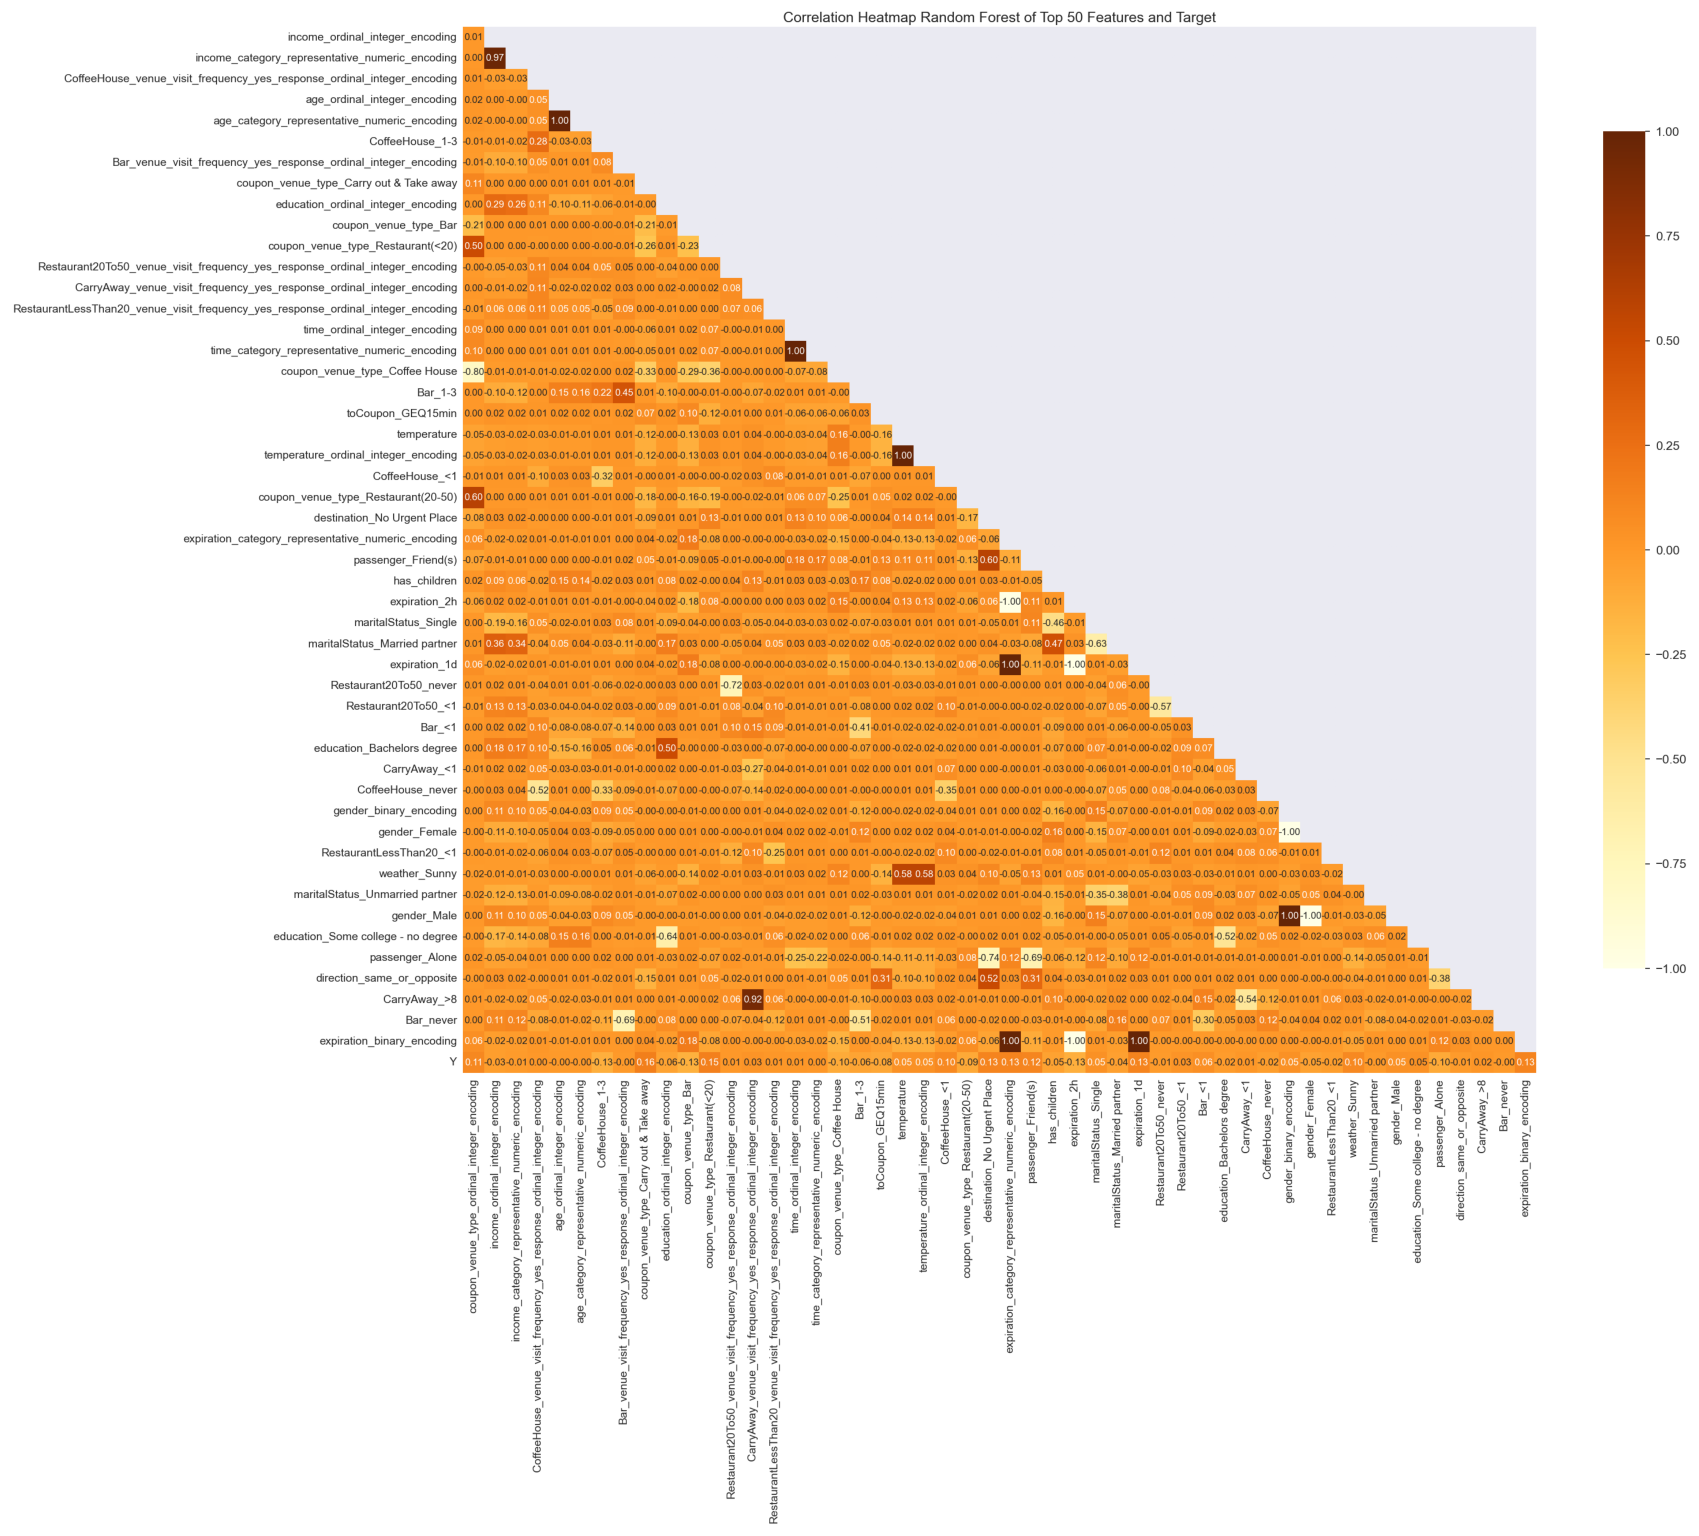

time: 864 ms (started: 2022-11-30 20:18:16 -08:00)


In [98]:
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_train_top_50_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 50 features and target

    df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 50 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [99]:
#categories of top 25 features???

pl(column_name_list_random_forest_classifier_top_25_by_feature_importance)

#coupon_venue_type - coupon venue type

#temperature - outside temperature

#expiration - time til expiration

#CoffeeHouse - coffee house visits per month

25


['coupon_venue_type_ordinal_integer_encoding',
 'income_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'CoffeeHouse_1-3',
 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Carry out & Take away',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Restaurant(<20)',
 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'Bar_1-3',
 'toCoupon_GEQ15min',
 'temperature',
 'temperature_ordinal_integer_encoding',
 'CoffeeHouse_<1',
 'c

time: 2.84 ms (started: 2022-11-30 20:18:17 -08:00)


<font size="5"><a id='[Modeling_Test_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>


<font size="6"><a id='[Modeling_Test_Results]'>**Modeling Test Results**</a> </font>

# Get Metrics Conversion Rate, Number of Conversions, Recall per Coupon Venue Type

### Get Data Frame Random Forest Prediction Probability, Gradient Boosting Prediction Probability, Y Actual, Coupon Venue Type

In [100]:
## Get Prediction Probabilities for Gradient Boosting, Prediction Probabilities for Random Forest, Y_actual, and coupon venue type
Y_test_random_forest_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_random_forest_prediction_probability = pd.DataFrame(Y_test_random_forest_prediction_probability_class0_class1_ndarray).loc[:, 1]


Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_gradient_boosting_prediction_probability = pd.DataFrame(Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray).loc[:, 1]


df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type = \
pd.concat([df_Y_test_random_forest_prediction_probability.to_frame().rename(columns={1:'Y_test_random_forest_prediction_probability'}), 
           df_Y_test_gradient_boosting_prediction_probability.to_frame().rename(columns={1:'Y_test_gradient_boosting_prediction_probability'}), 
           data_frame_collection['Y_test'].reset_index(drop=True),
           df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True)], axis=1)

p(df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type)


(2537, 4)


,Y_test_random_forest_prediction_probability,Y_test_gradient_boosting_prediction_probability,Y,coupon_venue_type
0,0.063081,0.000083,0,Coffee House
1,0.075221,0.000022,0,Coffee House
2,0.498031,0.727012,0,Coffee House
3,0.139583,0.101985,0,Restaurant(20-50)
4,0.620000,0.981180,1,Coffee House
2532,0.240637,0.954699,0,Restaurant(<20)
2533,0.474750,0.097020,1,Coffee House
2534,0.249458,0.000141,0,Bar
2535,0.615000,0.923828,1,Carry out & Take away
2536,0.860769,0.996709,1,Carry out & Take away


time: 144 ms (started: 2022-11-30 20:18:17 -08:00)



### Get Y Test Model Predictions with .9 Precision and .8 Recall Per Venue Type: Coffee House, Bar, Carry Out & Take Away, Inexpensive Restaurant, Expensive Restaurant

In [101]:
Y_test_model_prediction_data_frame_collection = {}


# Get Y Test Gradient Boosting Predictions with .9 Precision for Coffee House Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='precision', metric_quantity='dot9', coupon_name='Coffee House', coupon_name_short='coffee_house', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)

# Get Y Test Gradient Boosting Predictions with .8 Recall for Coffee House Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='recall', metric_quantity='dot8', coupon_name='Coffee House', coupon_name_short='coffee_house', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)



# Get Y Test Gradient Boosting Predictions with .9 Precision for Bar Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='random_forest', metric_name='precision', metric_quantity='dot9', coupon_name='Bar', coupon_name_short='bar', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)

# Get Y Test Gradient Boosting Predictions with .8 Recall for Bar Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='recall', metric_quantity='dot8', coupon_name='Bar', coupon_name_short='bar', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)




# Get Y Test Gradient Boosting Predictions with .9 Precision for Take Out Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='precision', metric_quantity='dot9', coupon_name='Carry out & Take away', coupon_name_short = 'takeout', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)

# Get Y Test Gradient Boosting Predictions with .8 Recall for Bar Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='recall', metric_quantity='dot8', coupon_name='Carry out & Take away', coupon_name_short='takeout', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)



# Get Y Test Gradient Boosting Predictions with .9 Precision for Inexpensive Restaurant Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='precision', metric_quantity='dot9', coupon_name='Restaurant(<20)', coupon_name_short='inexpensive_restaurant', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)

# Get Y Test Gradient Boosting Predictions with .8 Recall for Inexpensive Restaurant Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='recall', metric_quantity='dot8', coupon_name='Restaurant(<20)', coupon_name_short='inexpensive_restaurant', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)



# Get Y Test Gradient Boosting Predictions with .9 Precision for Expensive Restaurant Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='precision', metric_quantity='dot9', coupon_name='Restaurant(20-50)', coupon_name_short='expensive_restaurant', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)

# Get Y Test Gradient Boosting Predictions with .8 Recall for Expensive Restaurant Coupons
Y_test_model_prediction_data_frame_collection, key = icr.get_model_predictions_decision_threshold_metric_aim_coupon_venue_type(model_name='gradient_boosting', metric_name='recall', metric_quantity='dot8', coupon_name='Restaurant(20-50)', coupon_name_short='expensive_restaurant', Y_test_model_prediction_data_frame_collection=Y_test_model_prediction_data_frame_collection, df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, decision_threshold_collection=decision_threshold_collection)


# Combine Model Prediction by Metric Per Coupon Venue Type
data_frame_key_list = list(Y_test_model_prediction_data_frame_collection.keys())

data_frame_list = [Y_test_model_prediction_data_frame_collection[key] for key in data_frame_key_list]

data_frame_list += [data_frame_collection['Y_test'].reset_index(drop=True).rename(columns={'Y':'Y_test'}),df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True)]

df_model_precision_recall_coupon_type = pd.concat(data_frame_list, axis=1)
p(df_model_precision_recall_coupon_type)


(2537, 12)


,gradient_boosting_prediction_precision_dot9_coffee_house_coupon,gradient_boosting_prediction_recall_dot8_coffee_house_coupon,random_forest_prediction_precision_dot9_bar_coupon,gradient_boosting_prediction_recall_dot8_bar_coupon,gradient_boosting_prediction_precision_dot9_takeout_coupon,gradient_boosting_prediction_recall_dot8_takeout_coupon,gradient_boosting_prediction_precision_dot9_inexpensive_restaurant_coupon,gradient_boosting_prediction_recall_dot8_inexpensive_restaurant_coupon,gradient_boosting_prediction_precision_dot9_expensive_restaurant_coupon,gradient_boosting_prediction_recall_dot8_expensive_restaurant_coupon,Y_test,coupon_venue_type
0,0,0,0,0,0,0,0,0,0,0,0,Coffee House
1,0,0,0,0,0,0,0,0,0,0,0,Coffee House
2,0,1,0,1,0,0,0,0,0,1,0,Coffee House
3,0,0,0,0,0,0,0,0,0,1,0,Restaurant(20-50)
4,1,1,0,1,0,1,0,1,0,1,1,Coffee House
2532,1,1,0,1,0,1,0,1,0,1,0,Restaurant(<20)
2533,0,0,0,0,0,0,0,0,0,1,1,Coffee House
2534,0,0,0,0,0,0,0,0,0,0,0,Bar
2535,1,1,0,1,0,1,0,1,0,1,1,Carry out & Take away
2536,1,1,1,1,0,1,1,1,0,1,1,Carry out & Take away


time: 20.7 ms (started: 2022-11-30 20:18:17 -08:00)


### Calculate Metrics Conversion Rate, Recall, Number of Conversions, Number of Conversion Predicted, Number of Conversions Possible By Coupon Venue Type: Coffee House, Bar, Take Out, Inexpensive Restaurant, Expensive Restaurant

In [102]:
model_name = 'gradient_boosting'
metric_name = 'precision'
metric_quantity = 'dot9'
coupon_name = 'Coffee House'
coupon_name_short = 'coffee_house'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Coffee House
precision: 0.8324175824175825
recall: 0.7096018735362998
number_of_conversions_correctly_predicted: 303
number_of_conversions_predicted: 364
number_of_conversions: 427
time: 5.26 ms (started: 2022-11-30 20:18:17 -08:00)


In [103]:
model_name = 'gradient_boosting'
metric_name = 'recall'
metric_quantity = 'dot8'
coupon_name = 'Coffee House'
coupon_name_short = 'coffee_house'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Coffee House
precision: 0.7636363636363637
recall: 0.7868852459016393
number_of_conversions_correctly_predicted: 336
number_of_conversions_predicted: 440
number_of_conversions: 427
time: 5.24 ms (started: 2022-11-30 20:18:17 -08:00)


In [104]:
model_name = 'random_forest'
metric_name = 'precision'
metric_quantity = 'dot9'
coupon_name = 'Bar'
coupon_name_short = 'bar'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Bar
precision: 0.8780487804878049
recall: 0.23076923076923078
number_of_conversions_correctly_predicted: 36
number_of_conversions_predicted: 41
number_of_conversions: 156
time: 4.96 ms (started: 2022-11-30 20:18:17 -08:00)


In [105]:
model_name = 'gradient_boosting'
metric_name = 'recall'
metric_quantity = 'dot8'
coupon_name = 'Bar'
coupon_name_short = 'bar'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Bar
precision: 0.6616915422885572
recall: 0.8525641025641025
number_of_conversions_correctly_predicted: 133
number_of_conversions_predicted: 201
number_of_conversions: 156
time: 4.27 ms (started: 2022-11-30 20:18:17 -08:00)


In [106]:
model_name = 'gradient_boosting'
metric_name = 'precision'
metric_quantity = 'dot9'
coupon_name = 'Carry out & Take away'
coupon_name_short = 'takeout'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Carry out & Take away
precision: 0.896774193548387
recall: 0.38292011019283745
number_of_conversions_correctly_predicted: 139
number_of_conversions_predicted: 155
number_of_conversions: 363
time: 4.17 ms (started: 2022-11-30 20:18:17 -08:00)


In [107]:
model_name = 'gradient_boosting'
metric_name = 'recall'
metric_quantity = 'dot8'
coupon_name = 'Carry out & Take away'
coupon_name_short = 'takeout'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Carry out & Take away
precision: 0.857566765578635
recall: 0.7961432506887053
number_of_conversions_correctly_predicted: 289
number_of_conversions_predicted: 337
number_of_conversions: 363
time: 4.38 ms (started: 2022-11-30 20:18:17 -08:00)


In [108]:
model_name = 'gradient_boosting'
metric_name = 'precision'
metric_quantity = 'dot9'
coupon_name = "Restaurant(<20)"
coupon_name_short = 'inexpensive_restaurant'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Restaurant(<20)
precision: 0.8987854251012146
recall: 0.6032608695652174
number_of_conversions_correctly_predicted: 222
number_of_conversions_predicted: 247
number_of_conversions: 368
time: 4.37 ms (started: 2022-11-30 20:18:17 -08:00)


In [109]:
model_name = 'gradient_boosting'
metric_name = 'recall'
metric_quantity = 'dot8'
coupon_name = 'Restaurant(<20)'
coupon_name_short = 'inexpensive_restaurant'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Restaurant(<20)
precision: 0.8383233532934131
recall: 0.7608695652173914
number_of_conversions_correctly_predicted: 280
number_of_conversions_predicted: 334
number_of_conversions: 368
time: 4.51 ms (started: 2022-11-30 20:18:17 -08:00)


In [110]:
model_name = 'gradient_boosting'
metric_name = 'precision'
metric_quantity = 'dot9'
coupon_name = 'Restaurant(20-50)'
coupon_name_short = 'expensive_restaurant'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Restaurant(20-50)
precision: 1.0
recall: 0.02962962962962963
number_of_conversions_correctly_predicted: 4
number_of_conversions_predicted: 4
number_of_conversions: 135
time: 4.85 ms (started: 2022-11-30 20:18:17 -08:00)


In [111]:
model_name = 'gradient_boosting'
metric_name = 'recall'
metric_quantity = 'dot8'
coupon_name = 'Restaurant(20-50)'
coupon_name_short = 'expensive_restaurant'

column_name = model_name + '_prediction_' + metric_name + '_' + metric_quantity + '_' + coupon_name_short + '_coupon'

icr.get_metrics_by_venue_type(df=df_model_precision_recall_coupon_type, coupon_venue_type=coupon_name, prediction_column_name=column_name)



coupon_venue_type: Restaurant(20-50)
precision: 0.5567010309278351
recall: 0.8
number_of_conversions_correctly_predicted: 108
number_of_conversions_predicted: 194
number_of_conversions: 135
time: 4.51 ms (started: 2022-11-30 20:18:17 -08:00)


### Get Random Forest Predictions by Decision Threshold for .9 Precision

In [112]:
random_forest_decision_threshold_precision_90 = df_random_forest_decision_threshold_precision_recall.loc[df_random_forest_decision_threshold_precision_recall.loc[:, 'random_forest_precision'] >= .9, 'random_forest_decision_threshold'].iloc[0]

Y_test_random_forest_prediction_probability_list = df_Y_test_random_forest_prediction_probability.to_list()

Y_test_prediction_list = [1 if prediction_probability > random_forest_decision_threshold_precision_90 else 0 for prediction_probability in Y_test_random_forest_prediction_probability_list]

df_Y_test_prediction = pd.DataFrame(Y_test_prediction_list, columns=['Y_test_predicted'])

p(df_Y_test_prediction)


(2537, 1)


,Y_test_predicted
0,0
1,0
2,0
3,0
4,0
2532,0
2533,0
2534,0
2535,0
2536,1


time: 5.08 ms (started: 2022-11-30 20:18:17 -08:00)


In [113]:
#get precision, recall, number of conversions

print('OVERALL: Random Forest Precision .9')

random_forest_test_precision = precision_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_prediction)
print('random_forest_test_precision: ' + str(random_forest_test_precision))

random_forest_test_recall = recall_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_prediction)
print('random_forest_test_recall: ' + str(random_forest_test_recall))

confusion_matrix_ndarray = confusion_matrix(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_prediction)
tn, fp, fn, random_forest_test_number_of_conversions_correctly_predicted = confusion_matrix_ndarray.ravel()
print('random_forest_test_number_of_conversions_correctly_predicted: ' + str(random_forest_test_number_of_conversions_correctly_predicted))

random_forest_test_number_of_conversions_predicted = \
random_forest_test_number_of_conversions_correctly_predicted + fp
print('random_forest_test_number_of_conversions_predicted: ' + str(random_forest_test_number_of_conversions_predicted))

random_forest_test_number_of_conversions = \
random_forest_test_number_of_conversions_correctly_predicted + fn
print('random_forest_test_number_of_conversions: ' + str(random_forest_test_number_of_conversions))



OVERALL: Random Forest Precision .9
random_forest_test_precision: 0.906764168190128
random_forest_test_recall: 0.34230503795721184
random_forest_test_number_of_conversions_correctly_predicted: 496
random_forest_test_number_of_conversions_predicted: 547
random_forest_test_number_of_conversions: 1449
time: 5.46 ms (started: 2022-11-30 20:18:17 -08:00)


## Get Random Forest Metrics Per Coupon Venue Type

### Get Random Forest Test Coupon Venue Type

In [114]:
df_random_forest_coupon_venue_type_y_actual_y_test_predicted = \
pd.concat([df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True), df_collection['Y_test'].reset_index(drop=True).rename('Y_test'), df_Y_test_prediction], axis=1)

p(df_random_forest_coupon_venue_type_y_actual_y_test_predicted)


(2537, 3)


,coupon_venue_type,Y_test,Y_test_predicted
0,Coffee House,0,0
1,Coffee House,0,0
2,Coffee House,0,0
3,Restaurant(20-50),0,0
4,Coffee House,1,0
2532,Restaurant(<20),0,0
2533,Coffee House,1,0
2534,Bar,0,0
2535,Carry out & Take away,1,0
2536,Carry out & Take away,1,1


time: 16.3 ms (started: 2022-11-30 20:18:17 -08:00)


In [115]:
coupon_venue_type_list = df_random_forest_coupon_venue_type_y_actual_y_test_predicted.loc[:, 'coupon_venue_type'].drop_duplicates().to_list()
pl(coupon_venue_type_list)

5


['Coffee House',
 'Restaurant(20-50)',
 'Bar',
 'Restaurant(<20)',
 'Carry out & Take away']

time: 2.74 ms (started: 2022-11-30 20:18:17 -08:00)


In [116]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[0], prediction_column_name='Y_test_predicted')


coupon_venue_type: Coffee House
precision: 0.8840579710144928
recall: 0.2857142857142857
number_of_conversions_correctly_predicted: 122
number_of_conversions_predicted: 138
number_of_conversions: 427
time: 4.79 ms (started: 2022-11-30 20:18:17 -08:00)


In [117]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[2], prediction_column_name='Y_test_predicted')


coupon_venue_type: Bar
precision: 0.95
recall: 0.12179487179487179
number_of_conversions_correctly_predicted: 19
number_of_conversions_predicted: 20
number_of_conversions: 156
time: 3.72 ms (started: 2022-11-30 20:18:17 -08:00)


In [118]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[4], prediction_column_name='Y_test_predicted')


coupon_venue_type: Carry out & Take away
precision: 0.9273743016759777
recall: 0.4573002754820937
number_of_conversions_correctly_predicted: 166
number_of_conversions_predicted: 179
number_of_conversions: 363
time: 4.45 ms (started: 2022-11-30 20:18:17 -08:00)


In [119]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[3], prediction_column_name='Y_test_predicted')


coupon_venue_type: Restaurant(<20)
precision: 0.8960396039603961
recall: 0.49184782608695654
number_of_conversions_correctly_predicted: 181
number_of_conversions_predicted: 202
number_of_conversions: 368
time: 4.08 ms (started: 2022-11-30 20:18:17 -08:00)


In [120]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[1], prediction_column_name='Y_test_predicted')


coupon_venue_type: Restaurant(20-50)
precision: 1.0
recall: 0.05925925925925926
number_of_conversions_correctly_predicted: 8
number_of_conversions_predicted: 8
number_of_conversions: 135
time: 4.64 ms (started: 2022-11-30 20:18:17 -08:00)


### Get Gradient Boosting Prediction Probabilities by Decision Threshold .8 Recall

In [121]:
# Get Gradient Boosting Decision Threshold
gradient_boosting_decision_threshold_recall_80 = df_gradient_boosting_decision_threshold_precision_recall.loc[df_gradient_boosting_decision_threshold_precision_recall.loc[:, 'gradient_boosting_recall'] >= .8, 'gradient_boosting_decision_threshold'].iloc[-1]

Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.predict_proba(data_frame_collection['X_test'])

df_Y_test_gradient_boosting_prediction_probability = pd.DataFrame(Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray).loc[:, 1]



time: 32.5 ms (started: 2022-11-30 20:18:17 -08:00)


In [122]:
Y_test_gradient_boosting_prediction_probability_list = df_Y_test_gradient_boosting_prediction_probability.to_list()

Y_test_gradient_boosting_prediction_list = [1 if prediction_probability > gradient_boosting_decision_threshold_recall_80 else 0 for prediction_probability in Y_test_gradient_boosting_prediction_probability_list]

df_Y_test_gradient_boosting_prediction = pd.DataFrame(Y_test_gradient_boosting_prediction_list, columns=['Y_test_predicted'])
p(df_Y_test_gradient_boosting_prediction)

(2537, 1)


,Y_test_predicted
0,0
1,0
2,1
3,0
4,1
2532,1
2533,0
2534,0
2535,1
2536,1


time: 5.48 ms (started: 2022-11-30 20:18:17 -08:00)


In [123]:
#get precision, recall, number of conversions

gradient_boosting_test_precision = precision_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_gradient_boosting_prediction)
print('gradient_boosting_test_precision: ' + str(gradient_boosting_test_precision))

gradient_boosting_test_recall = recall_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_gradient_boosting_prediction)
print('gradient_boosting_test_recall: ' + str(gradient_boosting_test_recall))

confusion_matrix_ndarray = confusion_matrix(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_gradient_boosting_prediction)
tn, fp, fn, gradient_boosting_test_number_of_conversions_correctly_predicted = confusion_matrix_ndarray.ravel()
print('gradient_boosting_test_number_of_conversions_correctly_predicted: ' + str(gradient_boosting_test_number_of_conversions_correctly_predicted))

gradient_boosting_test_number_of_conversions_predicted = gradient_boosting_test_number_of_conversions_correctly_predicted + fp
print('gradient_boosting_test_number_of_conversions_predicted: ' + str(gradient_boosting_test_number_of_conversions_predicted))


gradient_boosting_test_number_of_conversions = gradient_boosting_test_number_of_conversions_correctly_predicted + fn
print('gradient_boosting_test_number_of_conversions: ' + str(gradient_boosting_test_number_of_conversions))



gradient_boosting_test_precision: 0.7965753424657535
gradient_boosting_test_recall: 0.8026224982746721
gradient_boosting_test_number_of_conversions_correctly_predicted: 1163
gradient_boosting_test_number_of_conversions_predicted: 1460
gradient_boosting_test_number_of_conversions: 1449
time: 5.69 ms (started: 2022-11-30 20:18:17 -08:00)


## Get Gradient Boosting Metrics by Coupon Venue Type

### Get Gradient Boosting Test Coupon Venue Type

In [124]:
df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted = \
pd.concat([df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True), df_collection['Y_test'].reset_index(drop=True).rename('Y_test'), df_Y_test_prediction], axis=1)

p(df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted)


(2537, 3)


,coupon_venue_type,Y_test,Y_test_predicted
0,Coffee House,0,0
1,Coffee House,0,0
2,Coffee House,0,0
3,Restaurant(20-50),0,0
4,Coffee House,1,0
2532,Restaurant(<20),0,0
2533,Coffee House,1,0
2534,Bar,0,0
2535,Carry out & Take away,1,0
2536,Carry out & Take away,1,1


time: 5.37 ms (started: 2022-11-30 20:18:17 -08:00)


In [125]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Coffee House', prediction_column_name='Y_test_predicted')

coupon_venue_type: Coffee House
precision: 0.8840579710144928
recall: 0.2857142857142857
number_of_conversions_correctly_predicted: 122
number_of_conversions_predicted: 138
number_of_conversions: 427
time: 4.71 ms (started: 2022-11-30 20:18:17 -08:00)


In [126]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Bar', prediction_column_name='Y_test_predicted')

coupon_venue_type: Bar
precision: 0.95
recall: 0.12179487179487179
number_of_conversions_correctly_predicted: 19
number_of_conversions_predicted: 20
number_of_conversions: 156
time: 4.17 ms (started: 2022-11-30 20:18:17 -08:00)


In [127]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Carry out & Take away', prediction_column_name='Y_test_predicted')

coupon_venue_type: Carry out & Take away
precision: 0.9273743016759777
recall: 0.4573002754820937
number_of_conversions_correctly_predicted: 166
number_of_conversions_predicted: 179
number_of_conversions: 363
time: 4.79 ms (started: 2022-11-30 20:18:17 -08:00)


In [128]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Restaurant(<20)', prediction_column_name='Y_test_predicted')

coupon_venue_type: Restaurant(<20)
precision: 0.8960396039603961
recall: 0.49184782608695654
number_of_conversions_correctly_predicted: 181
number_of_conversions_predicted: 202
number_of_conversions: 368
time: 3.9 ms (started: 2022-11-30 20:18:17 -08:00)


In [129]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Restaurant(20-50)', prediction_column_name='Y_test_predicted')

coupon_venue_type: Restaurant(20-50)
precision: 1.0
recall: 0.05925925925925926
number_of_conversions_correctly_predicted: 8
number_of_conversions_predicted: 8
number_of_conversions: 135
time: 4.09 ms (started: 2022-11-30 20:18:18 -08:00)


### Random Forest Classifier: All Data, Reduced Features

In [130]:
#drop repeated features with 99-100% correlation
drop_features_list = ['income_ordinal_integer_encoding',
                      'age_ordinal_integer_encoding',
                      'time_ordinal_integer_encoding',
                      'temperature_ordinal_integer_encoding']

#get all preprocessed data
df_X_train_test = pd.concat([data_frame_collection['X_train'], data_frame_collection['X_test']], axis=0).drop(columns=drop_features_list)
df_Y_train_test = pd.concat([data_frame_collection['Y_train'], data_frame_collection['Y_test']], axis=0)

#get data frame with all data
df_X_train_test_Y_train_test = pd.concat([df_X_train_test, df_Y_train_test], axis=1)
del df_X_train_test, df_Y_train_test

#train random forest classifer all data
random_forest_classifier_all_data = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5, n_estimators=200, random_state=200)
random_forest_classifier_all_data.fit(df_X_train_test_Y_train_test.drop(columns=['Y']), df_X_train_test_Y_train_test.loc[:, 'Y'])
random_forest_classifier_all_data_fit = random_forest_classifier_all_data
del random_forest_classifier_all_data



#save random forest classifier all data
model_readback = icr.return_saved_model_if_it_exists(filename=random_forest_classifier_all_data_fit_filename)
if model_readback != None:
    random_forest_classifier_all_data_fit = model_readback
else:   
    #add model environment data to model
    random_forest_classifier_all_data_fit.version = model_version
    random_forest_classifier_all_data_fit.pandas_version = pd.__version__
    random_forest_classifier_all_data_fit.numpy_version = np.__version__
    random_forest_classifier_all_data_fit.sklearn_version = sklearn_version
    random_forest_classifier_all_data_fit.X_columns = [column_name for column_name in df_X_train_test_Y_train_test.drop(columns=['Y']).columns]
    random_forest_classifier_all_data_fit.build_datetime = datetime.datetime.now()
    
    #save it
    random_forest_classifier_all_data_fit = icr.save_and_return_model(random_forest_classifier_all_data_fit, filename=random_forest_classifier_all_data_fit_filename)
    
random_forest_classifier_all_data_fit


This file already exists


RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                       n_estimators=200, random_state=200)

time: 3.2 s (started: 2022-11-30 20:18:18 -08:00)


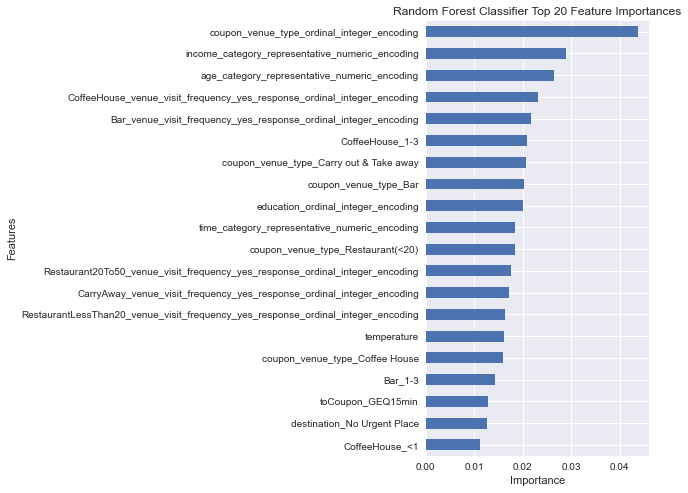

time: 294 ms (started: 2022-11-30 20:18:21 -08:00)


In [131]:
#get feature importants plot

plt.subplots(figsize=(4, 8))

random_forest_classifier_all_data_fit_feature_importances = random_forest_classifier_all_data_fit.feature_importances_
series_random_forest_classifier_all_data_fit_feature_importances = pd.Series(random_forest_classifier_all_data_fit_feature_importances, 
                                                                             index=random_forest_classifier_all_data_fit.X_columns).sort_values(ascending=False)

series_random_forest_classifier_all_data_fit_feature_importances[0:20].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top 20 Feature Importances');

plt.savefig('../reports/figures/figure_random_forest_classifier_all_data_fit_top_20_feature_importances_v' + filename_version + '.png', bbox_inches='tight', dpi=100)



In [132]:
df_coupon_venue_type_count = \
df.loc[:, 'coupon_venue_type'].value_counts(ascending=True)
#df.loc[:, 'coupon_venue_type_ordinal_integer_encoding'].replace({1:'Coffee House', 2:'Bar', 3:'Carry out & Take away', 4:'Restaurant(<20)', 5:'Restaurant(20-50)'}).value_counts(ascending=True)

p(df_coupon_venue_type_count)



Restaurant(20-50)        1492
Bar                      2017
Carry out & Take away    2393
Restaurant(<20)          2786
Coffee House             3996
Name: coupon_venue_type, dtype: int64

time: 2.74 ms (started: 2022-11-30 20:18:21 -08:00)


<BarContainer object of 5 artists>

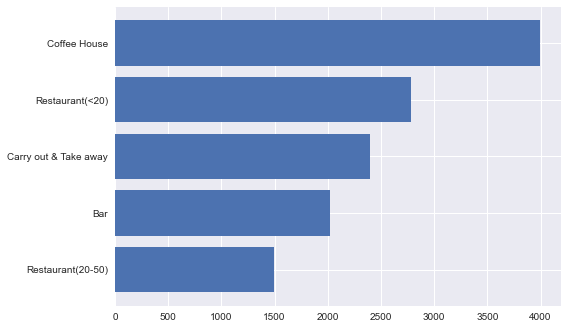

time: 65 ms (started: 2022-11-30 20:18:21 -08:00)


In [133]:
plt.barh(y=df_coupon_venue_type_count.index, width=df_coupon_venue_type_count.values)


In [134]:
df_Y_coupon_venue_type_count = df.groupby(['Y', 'coupon_venue_type']).count().iloc[:, 0].reset_index().rename(columns={'destination':'coupon_venue_type_count'})
df_Y_coupon_venue_type_count



,Y,coupon_venue_type,coupon_venue_type_count
0,0,Bar,1190
1,0,Carry out & Take away,633
2,0,Coffee House,2001
3,0,Restaurant(20-50),834
4,0,Restaurant(<20),816
5,1,Bar,827
6,1,Carry out & Take away,1760
7,1,Coffee House,1995
8,1,Restaurant(20-50),658
9,1,Restaurant(<20),1970


time: 28.1 ms (started: 2022-11-30 20:18:21 -08:00)


In [135]:
df_coupon_venue_type_denied_accepted_coupon_count = \
df_Y_coupon_venue_type_count.pivot(index='coupon_venue_type', columns='Y', values='coupon_venue_type_count').rename(columns={0:'Denied Coupon', 1:'Accepted Coupon'})

Y,Denied Coupon,Accepted Coupon
coupon_venue_type,,
Bar,1190,827
Carry out & Take away,633,1760
Coffee House,2001,1995
Restaurant(20-50),834,658
Restaurant(<20),816,1970


time: 4.78 ms (started: 2022-11-30 20:18:21 -08:00)


In [136]:
#plt.figure(figsize=(10, 10))

#sns.set(style="darkgrid")

df_coupon_venue_type_denied_accepted_coupon_count.plot(x = 'gender',
                                                       kind = 'bar',
                                                       stacked = True,
                                                       title = 'Income Count and Percentage per Gender',
                                                       mark_right = True,
                                                       color=['#8c6bb1', '#41ab5d'],
                                                       figsize=(12, 10))

df_total = df_gender_income["<=50K"] + df_gender_income[">50K"]
df_rel = df_gender_income[df_gender_income.columns[1:]].div(df_total, 0) * 100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df_gender_income.iloc[:, 1:].cumsum(1)[n],
                                         df_gender_income[n], df_rel[n])):
        plt.text(i, 
                 cs - ab / 2, 
                 str(np.round(pc, 1)) + '%', va = 'center', 
                 ha = 'center', 
                 rotation = 0, 
                 fontsize = 14)
        
plt.ylabel('count')

plt.show()

NameError: name 'df_gender_income' is not defined

time: 311 ms (started: 2022-11-30 20:18:21 -08:00)


In [ ]:
df_Y_coupon_venue_type_proportion = df.groupby(['Y', 'coupon_venue_type']).agg({'coupon_venue_type': 'count'}).groupby(level=1).apply(lambda x: x / float(x.sum()))
df_Y_coupon_venue_type_proportion = df_Y_coupon_venue_type_proportion.rename(columns={'coupon_venue_type':'coupon_venue_type_proportion'}).reset_index()
df_Y_coupon_venue_type_proportion.sort_values(['Y', 'coupon_venue_type_proportion', 'coupon_venue_type'], ascending=False)


In [ ]:
df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y'] == 0, :]

In [ ]:
#stacked bar with coupon acceptance rate
import matplotlib.pyplot as plt


labels = df_coupon_venue_type_count.index.to_list()
refuse_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==0, 'coupon_venue_type_proportion'].to_list()
accept_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==1, 'coupon_venue_type_proportion'].to_list()
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, refuse_coupon, width, label='Refuse Coupon')
ax.bar(labels, accept_coupon, width, bottom=refuse_coupon, label='Accept Coupon')

ax.set_ylabel(ylabel='Count', fontsize=14)
ax.set_xlabel(xlabel='Coupon Venue Type', fontsize=14)
ax.set_title('Coupon Venue Type Count By Coupon Acceptance', fontsize=18)
ax.legend()

plt.show()

In [ ]:
df_Y_coupon_venue_type_proportion

In [ ]:
df_Y_coupon_venue_type_proportion

In [ ]:
# Define the sorter
sorter = ['Carry out & Take away',
          'Restaurant(<20)',
          'Coffee House',
          'Restaurant(20-50)',
          'Bar']

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter, range(len(sorter))))

# Here is an example where 'Tm' is sorted first, that will 
# give the first row of the DataFrame df to contain TOT as 'Tm'
df_Y_coupon_venue_type_proportion.loc[:, 'coupon_venue_type_rank'] = \
df_Y_coupon_venue_type_proportion.loc[:, 'coupon_venue_type'].map(sorterIndex)


df_Y_coupon_venue_type_proportion = df_Y_coupon_venue_type_proportion.sort_values(['Y', 'coupon_venue_type_rank', ], ascending=[True , True])

#df_Y_coupon_venue_type_proportion = df_Y_coupon_venue_type_proportion.drop('coupon_venue_type_rank', 1)

df_Y_coupon_venue_type_proportion

In [ ]:
#stacked bar with coupon acceptance rate

labels = df_coupon_venue_type_count.index.to_list()
refuse_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==0, 'coupon_venue_type_proportion'].to_list()
accept_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==1, 'coupon_venue_type_proportion'].to_list()
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, accept_coupon, width, label='Accept Coupon', color='green')
ax.bar(labels, refuse_coupon, width, bottom=accept_coupon, label='Refuse Coupon', color='lightblue')

ax.set_ylabel(ylabel='Count', fontsize=14)
ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1,])
ax.set_xlabel(xlabel='Coupon Venue Type', fontsize=14)
ax.set_title('Coupon Venue Type Count By Coupon Acceptance', fontsize=18)
ax.legend()

plt.show()

In [ ]:
#^--- add percentages

In [ ]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
  
# load dataset
df = pd.read_excel("Hours.xlsx")
  
# view dataset
print(df)
  
# plot a Stacked Bar Chart using matplotlib
df.plot(
  x = 'Name', 
  kind = 'barh', 
  stacked = True, 
  title = 'Percentage Stacked Bar Graph', 
  mark_right = True)
  
df_total = df["Studied"] + df["Slept"] + df["Other"]
df_rel = df[df.columns[1:]].div(df_total, 0)*100
  
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], 
                                         df[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'center')

In [ ]:
#analytics shows proportion of scenarios when a survey participant accepts vs denies a coupon


In [ ]:
df_Y_coupon_accepted_coupon_venue_type = df.loc[df.loc[:, 'Y'] == 1, ['Y', 'coupon_venue_type']]
#p(df_Y_coupon_accepted_coupon_venue_type)

df_Y_coupon_denied_coupon_venue_type = df.loc[df.loc[:, 'Y'] == 0, ['Y', 'coupon_venue_type']]
p(df_Y_coupon_denied_coupon_venue_type)


In [ ]:
df.groupby(['Y', 'coupon_venue_type']).count().iloc[:, 0].reset_index().rename(columns={'destination':'count'})


In [ ]:
#stacked bar with coupon acceptance rate
import matplotlib.pyplot as plt


labels = df_coupon_venue_type_count.index.to_list()
refuse_coupon = [20, 35, 30, 35, 27]
accept_coupon = [25, 32, 34, 20, 25]
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, refuse_coupon, width, label='Refuse Coupon')
ax.bar(labels, accept_coupon, width, bottom=refuse_coupon, label='Accept Coupon')

ax.set_ylabel(ylabel='Count', fontsize=14)
ax.set_xlabel(xlabel='Coupon Venue Type', fontsize=14)
ax.set_title('Coupon Venue Type Count By Coupon Acceptance', fontsize=18)
ax.legend()

plt.show()

### Random Forest Classifier: All Data, Reduced Features

#### Get Random Forest Features By Importance

In [ ]:
#get and order random forest features by importance
random_forest_classifier_all_data_fit_feature_importances = random_forest_classifier_all_data_fit.feature_importances_
series_random_forest_classifier_all_data_fit_feature_importances = pd.Series(random_forest_classifier_all_data_fit_feature_importances,
                                                                             index=random_forest_classifier_all_data_fit.X_columns).sort_values(ascending=False)


#get top 25 and 50 features list
column_name_list_random_forest_classifier_all_data_top_50_by_feature_importance_target = series_random_forest_classifier_all_data_fit_feature_importances[0:50].index.to_list() + ['Y']
column_name_list_random_forest_classifier_all_data_top_25_by_feature_importance_target = series_random_forest_classifier_all_data_fit_feature_importances[0:25].index.to_list() + ['Y']

pl(column_name_list_random_forest_classifier_all_data_top_50_by_feature_importance_target)


#### Identify High Correlation Features For Drop

In [ ]:
#Identify High Correlation Features For Drop
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_all_data_top_25_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 25 features and target

    df_corr = df_X_train_test_Y_train_test.loc[:, column_name_list_random_forest_classifier_all_data_top_25_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 25 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()



In [ ]:
top_25_feature_importance_duplicate_like_features_list = \
['income_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'age_category_representative_numeric_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'temperature_ordinal_integer_encoding',
 'temperature']

top_25_feature_importance_duplicate_like_features_list_drop = \
['income_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'temperature_ordinal_integer_encoding']

pl(top_25_feature_importance_duplicate_like_features_list_drop)

In [ ]:
dir()